# Project
## Machine Learning - ITE-5310
### Humber College - December 2022
#### Name: Nguyen Anh Tuan Le
#### Student ID: N014141295

# FMA: A Dataset For Music Analysis Data Set features 106,574 tracks and includes song title, album, artist, genres; play counts, favorites, comments; description, biography, tags and features.

__[source](https://archive.ics.uci.edu/ml/datasets/FMA%3A+A+Dataset+For+Music+Analysis)__

- Data Set Information:
    - Nine audio features (consisting of 518 attributes) for each of the 106,574 tracks.
        - Nine audio features computed across time and summarized with seven statistics (mean, standard deviation, skew, kurtosis, median, minimum, maximum):
            - Chroma, 84 attributes
            - Tonnetz, 42 attributes
            - Mel Frequency Cepstral Coefficient (MFCC), 140 attributes
            - Spectral centroid, 7 attributes
            - Spectral bandwidth, 7 attributes
            - Spectral contrast, 49 attributes
            - Spectral rolloff, 7 attributes
            - Root Mean Square energy, 7 attributes
            - Zero-crossing rate, 7 attribute
    - Given the metadata, multiple problems can be explored: recommendation, genre recognition, artist identification, year prediction, music annotation, unsupervized categorization.


1. Import necessary libraries

In [4]:
import time
import utils as utils
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import Image
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer, PolynomialFeatures
from sklearn.svm import LinearSVC, SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from tqdm.notebook import tqdm_notebook
from scipy.stats import mode

%matplotlib inline

plt.rcParams['figure.figsize'] = (17, 5)

2. Load csv files

In [2]:
# per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks
tracks = utils.load('fma_metadata/tracks.csv')

# all 163 genres with name and parent (used to infer the genre hierarchy and top-level genres)
genres = utils.load('fma_metadata/genres.csv')

# common features extracted with librosa
features = utils.load('fma_metadata/features.csv')

# audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

3. Perform exploratory data analysis (EDA)

    1. Tracks

In [3]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   (album, comments)            106574 non-null  int64         
 1   (album, date_created)        103045 non-null  datetime64[ns]
 2   (album, date_released)       70294 non-null   datetime64[ns]
 3   (album, engineer)            15295 non-null   object        
 4   (album, favorites)           106574 non-null  int64         
 5   (album, id)                  106574 non-null  int64         
 6   (album, information)         83149 non-null   category      
 7   (album, listens)             106574 non-null  int64         
 8   (album, producer)            18060 non-null   object        
 9   (album, tags)                106574 non-null  object        
 10  (album, title)               105549 non-null  object        
 11  (album, tracks)           

In [5]:
tracks.describe()

album                                              \
            comments      favorites             id       listens   
count  106574.000000  106574.000000  106574.000000  1.065740e+05   
mean        0.394946       1.286927   12826.933914  3.212031e+04   
std         2.268915       3.133035    6290.261805  1.478532e+05   
min        -1.000000      -1.000000      -1.000000 -1.000000e+00   
25%         0.000000       0.000000    7793.000000  3.361000e+03   
50%         0.000000       0.000000   13374.000000  8.982000e+03   
75%         0.000000       1.000000   18203.000000  2.363500e+04   
max        53.000000      61.000000   22940.000000  3.564243e+06   

                             artist                                \
              tracks       comments      favorites             id   
count  106574.000000  106574.000000  106574.000000  106574.000000   
mean       19.721452       1.894702      30.041915   12036.770404   
std        39.943673       6.297679     100.511408    6881.420867   
min        -1.000000      -1.000000      -1.000000       1.000000   
25%         7.000000       0.000000       1.000000    6443.000000   
50%        11.000000       0.000000       5.000000   12029.500000   
75%        17.000000       1.000000      16.000000   18011.000000   
max       652.000000      79.000000     963.000000   24357.000000   

                                           track                 \
           latitude     longitude       bit_rate       comments   
count  44544.000000  44544.000000  106574.000000  106574.000000   
mean      39.901626    -38.668642  263274.695048       0.031621   
std       18.240860     65.237220   67623.443584       0.321993   
min      -45.878760   -157.526855      -1.000000       0.000000   
25%       39.271398    -79.997459  192000.000000       0.000000   
50%       41.387917    -73.554431  299914.000000       0.000000   
75%       48.856930      4.351710  320000.000000       0.000000   
max       67.286005    175.277000  448000.000000      37.000000   

                                                                  \
            duration      favorites      interest        listens   
count  106574.000000  106574.000000  1.065740e+05  106574.000000   
mean      277.849100       3.182521  3.541310e+03    2329.353548   
std       305.518553      13.513820  1.901743e+04    8028.070647   
min         0.000000       0.000000  2.000000e+00       0.000000   
25%       149.000000       0.000000  5.990000e+02     292.000000   
50%       216.000000       1.000000  1.314000e+03     764.000000   
75%       305.000000       3.000000  3.059000e+03    2018.000000   
max     18350.000000    1482.000000  3.293557e+06  543252.000000   

                      
              number  
count  106574.000000  
mean        8.260945  
std        15.243271  
min         0.000000  
25%         2.000000  
50%         5.000000  
75%         9.000000  
max       255.000000

In [6]:
tracks.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [7]:
tracks.dtypes

album   comments                      int64
        date_created         datetime64[ns]
        date_released        datetime64[ns]
        engineer                     object
        favorites                     int64
        id                            int64
        information                category
        listens                       int64
        producer                     object
        tags                         object
        title                        object
        tracks                        int64
        type                       category
artist  active_year_begin    datetime64[ns]
        active_year_end      datetime64[ns]
        associated_labels            object
        bio                        category
        comments                      int64
        date_created         datetime64[ns]
        favorites                     int64
        id                            int64
        latitude                    float64
        location                

<AxesSubplot: xlabel='None-None', ylabel='None-None'>

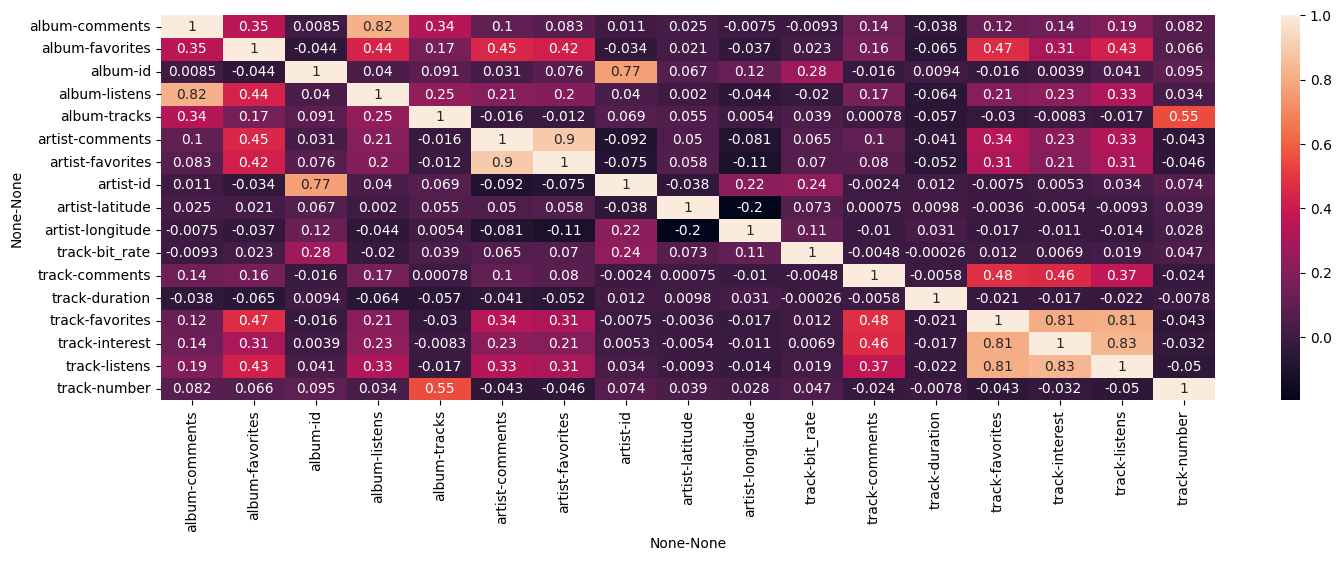

In [8]:
sns.heatmap(tracks.corr(numeric_only=True), annot=True)

- Strong Correlations
    - album-listens and album-comments: 0.82
    - artist-favorites and artist-comments: 0.9
    - track-interest and track-favorites: 0.81
    - track-listens and track-favorites: 0.81
    - track-listens and track-interest: 0.83

<AxesSubplot: xlabel='None-None', ylabel='None-None'>

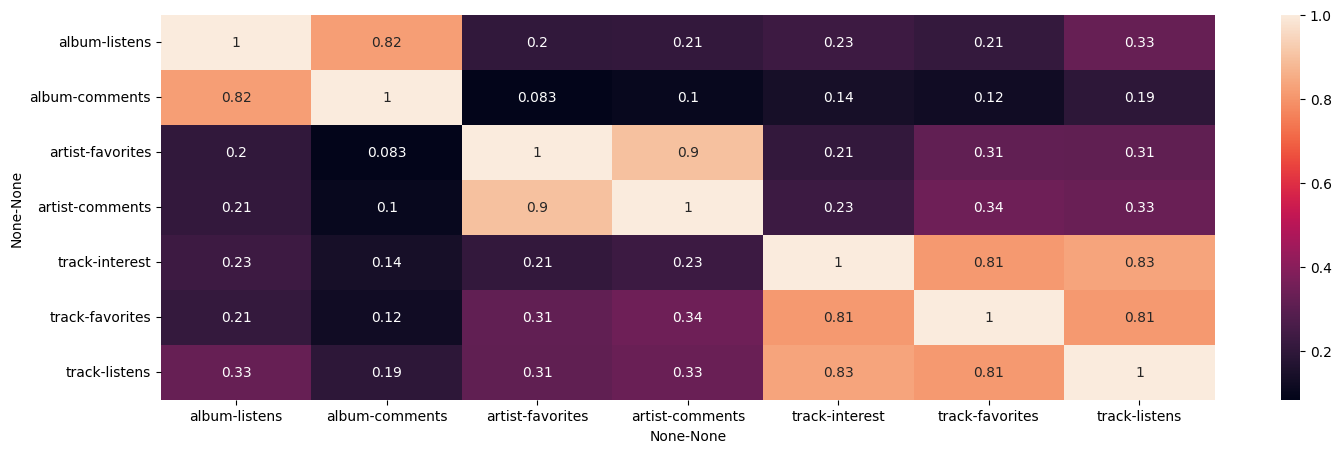

In [9]:
new_tracks = tracks.loc[:, [('album', 'listens'), ('album', 'comments'), ('artist', 'favorites'), ('artist', 'comments'), ('track', 'interest'), ('track', 'favorites'), ('track', 'listens')]]
sns.heatmap(new_tracks.corr(numeric_only=True), annot=True)

- Univariate Data Analysis

<AxesSubplot: xlabel='comments', ylabel='Count'>

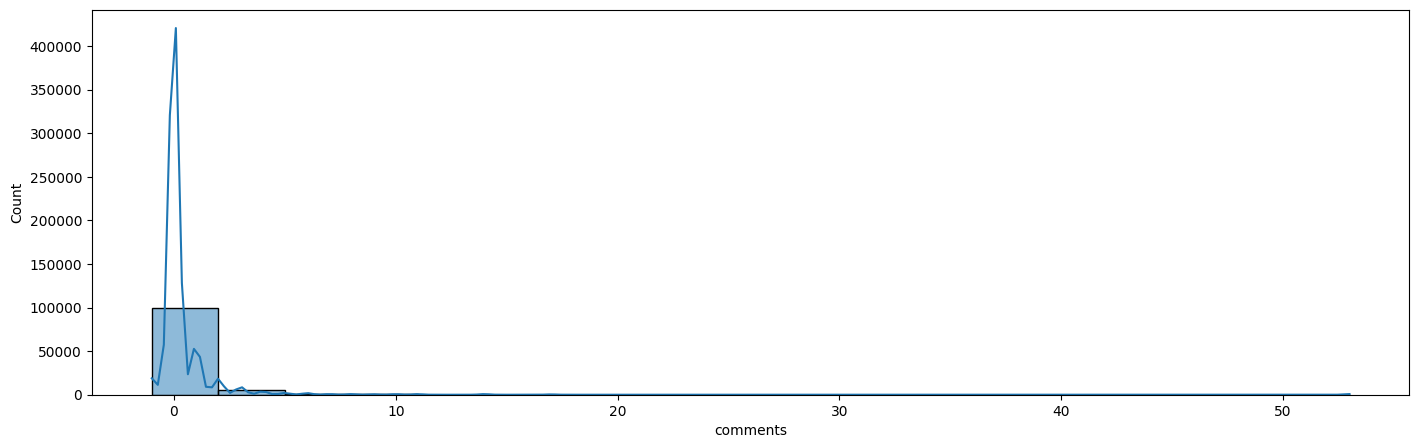

In [10]:
sns.histplot(tracks.album.comments, kde=True)

        - tracks.album.comments: has a positively skewed distribution with the most of the numbers of comments ranges from 0 to 2

<AxesSubplot: xlabel='listens', ylabel='Count'>

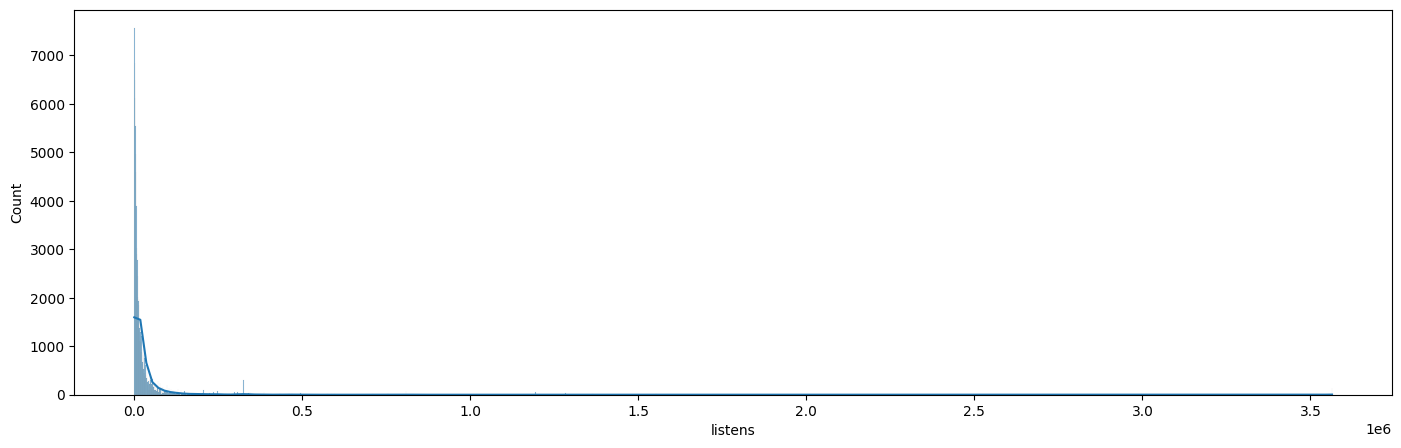

In [11]:
sns.histplot(tracks.album.listens, kde=True)

    - tracks.album.listens: projects a positively skewed distribution with a peak at 0

<AxesSubplot: xlabel='comments', ylabel='Count'>

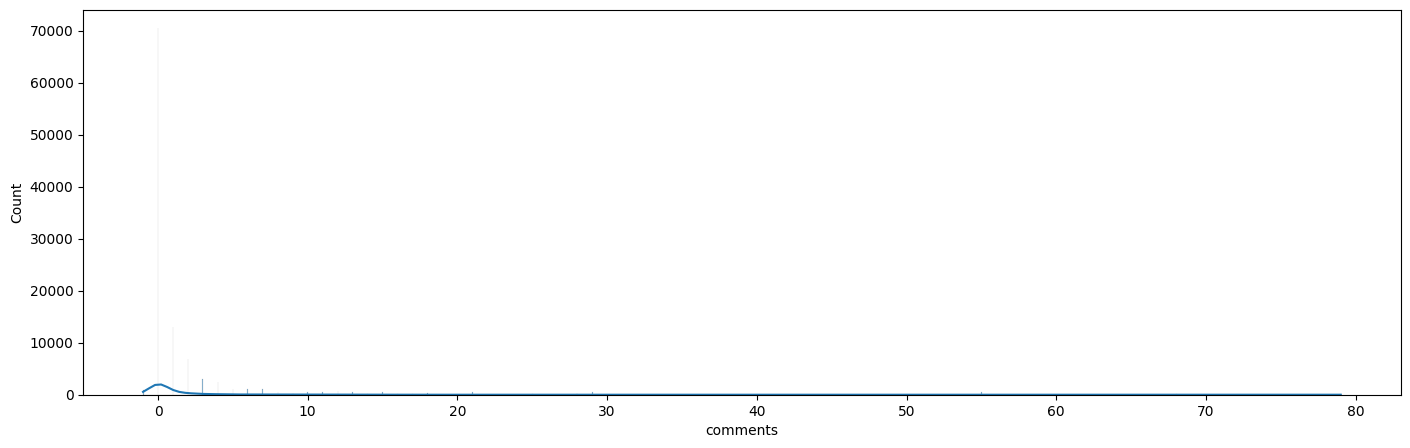

In [12]:
sns.histplot(tracks.artist.comments, kde=True)

    - tracks.artist.comments: has a slight negatively skewed distribution with a peak at 0

<AxesSubplot: xlabel='favorites', ylabel='Count'>

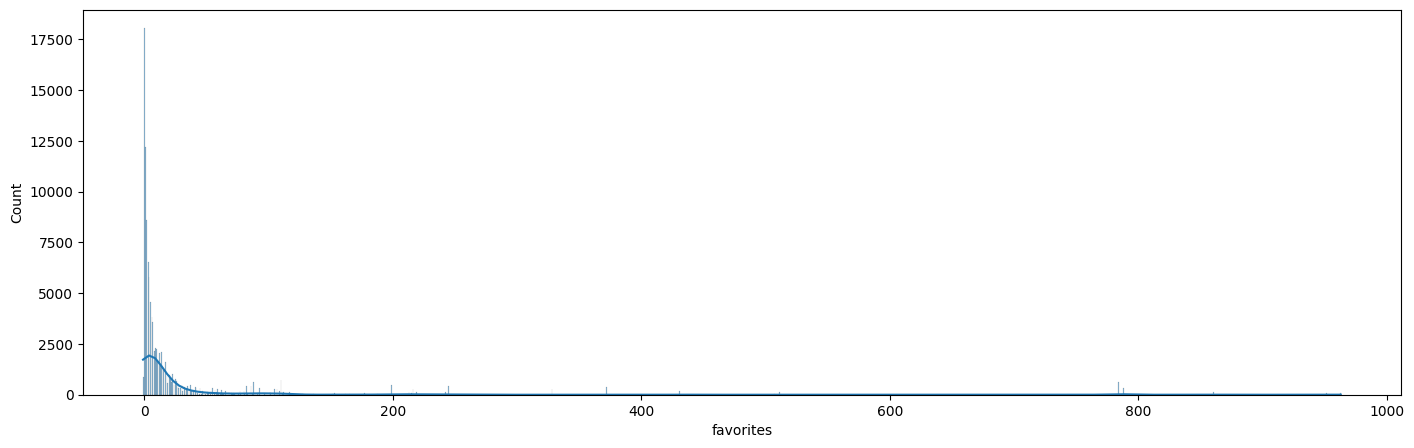

In [13]:
sns.histplot(tracks.artist.favorites, kde=True)

    - tracks.artist.favorites: follows a positively skewed distribution with the majority of the numbers of favorites is under 50

<AxesSubplot: xlabel='favorites', ylabel='Count'>

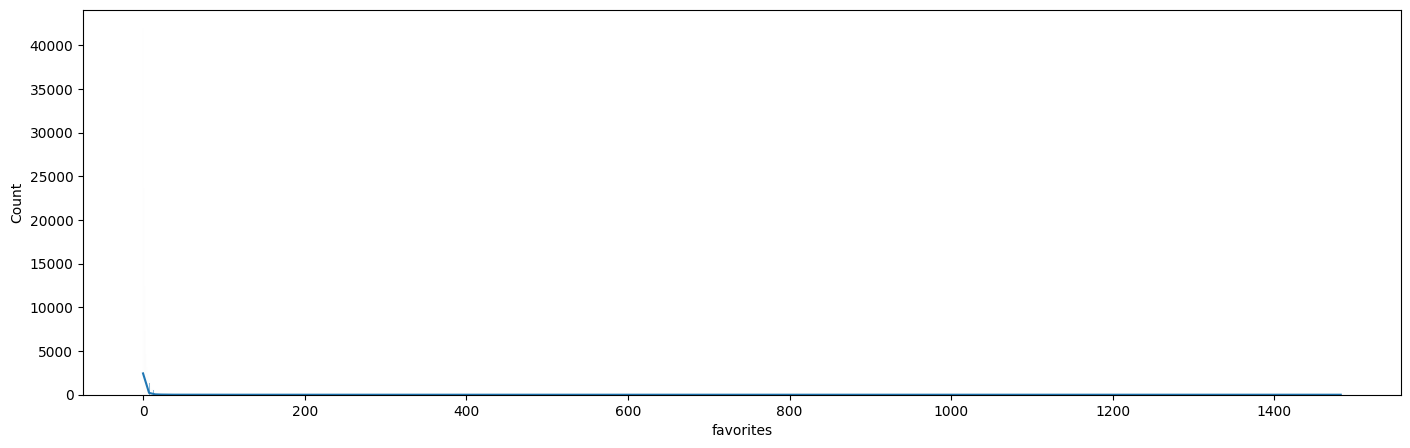

In [14]:
sns.histplot(tracks.track.favorites, kde=True)

    - tracks.track.favorites: has a slight negatively skewed distribution with a peak at 0

<AxesSubplot: xlabel='interest', ylabel='Count'>

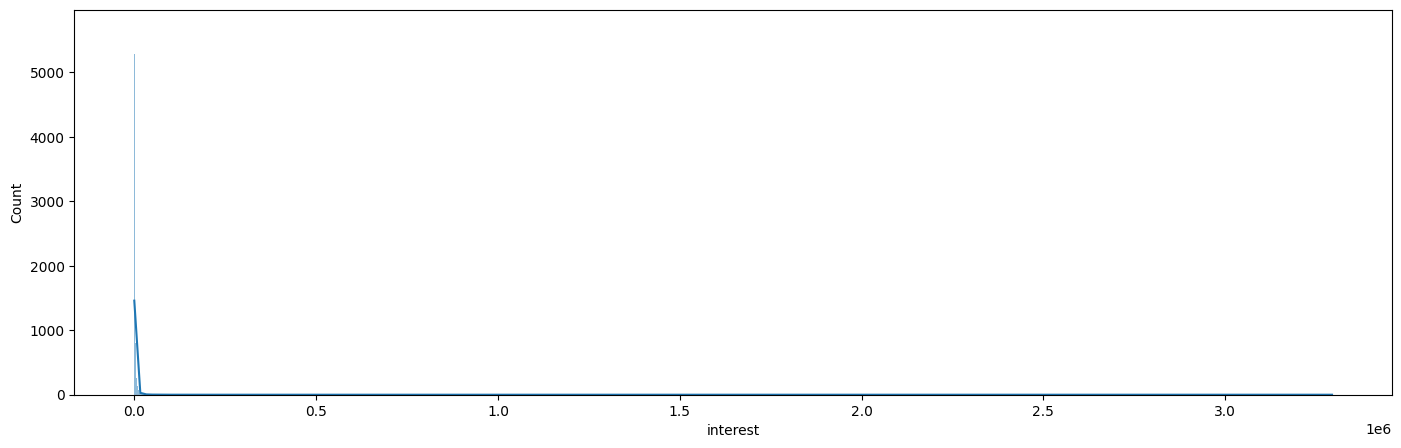

In [15]:
sns.histplot(tracks.track.interest, kde=True)

    - tracks.track.listen: has a slight negatively skewed distribution with the most of them hovers under 0.01 1e6

<AxesSubplot: xlabel='listens', ylabel='Count'>

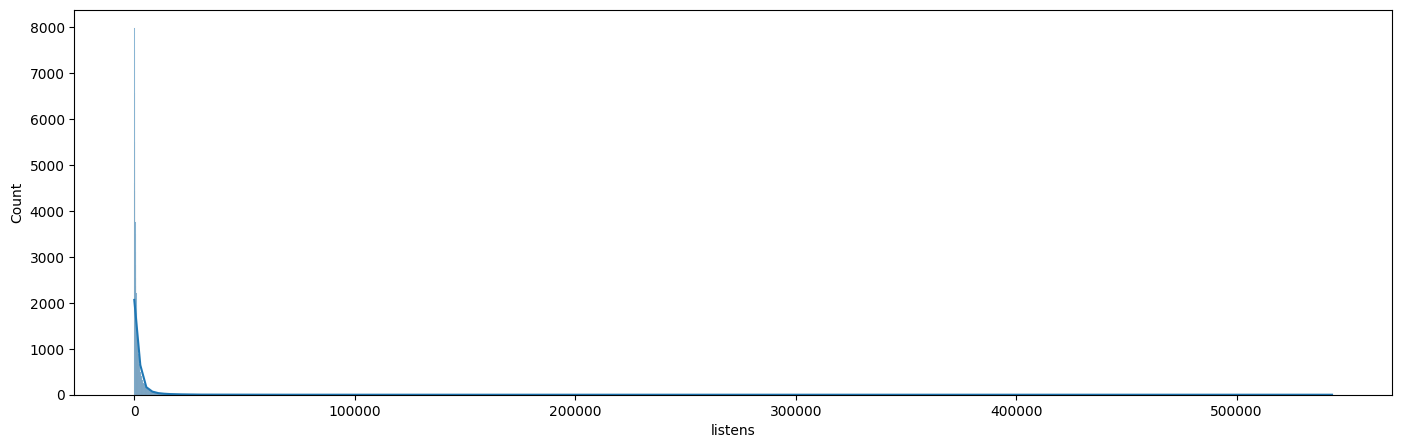

In [16]:
sns.histplot(tracks.track.listens, kde=True)

    - tracks.track.listen: has a negatively skewed distribution with the majority of them is under 10,000

- Bivariate Data Analysis

<AxesSubplot: xlabel='listens', ylabel='comments'>

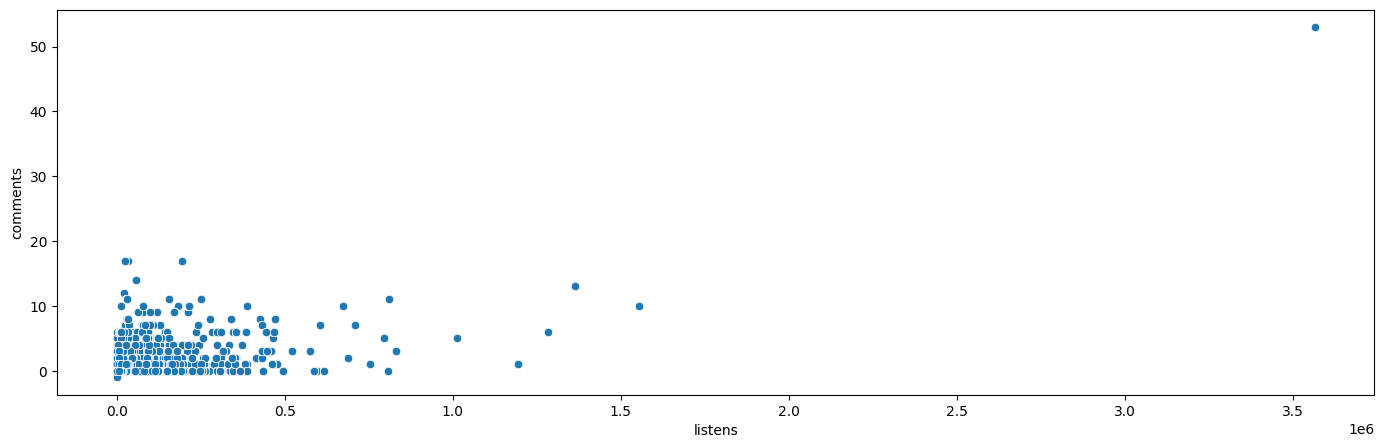

In [17]:
sns.scatterplot(x=tracks.album.listens, y=tracks.album.comments)

    - tracks.album.listens vs tracks.album.comments
        - direction: positive
        - form: non-linear
        - strength: moderate
        - outliers: yes

<AxesSubplot: xlabel='interest', ylabel='favorites'>

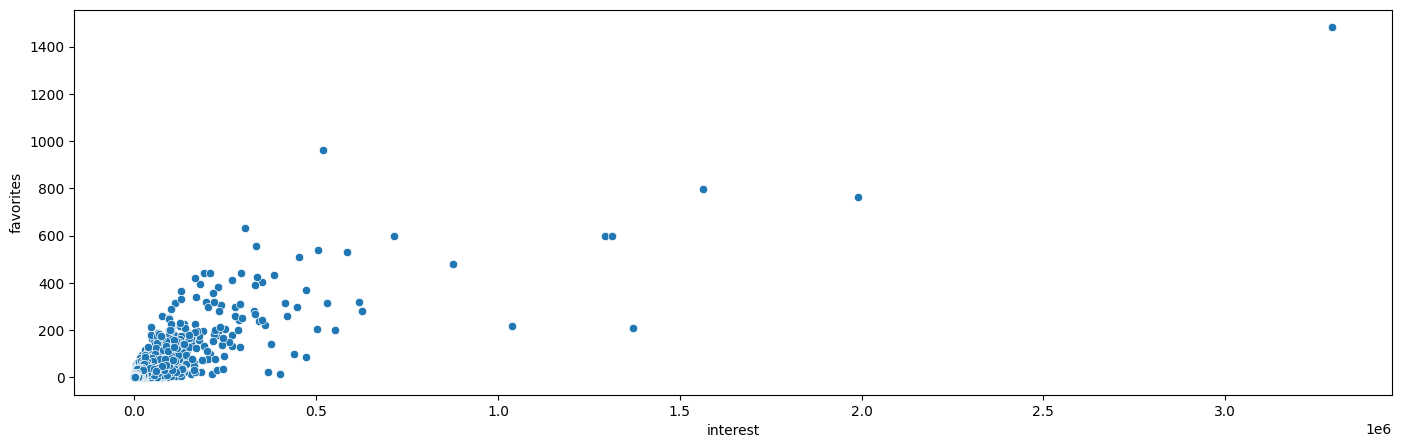

In [18]:
sns.scatterplot(x=tracks.track.interest, y=tracks.track.favorites)

    - tracks.track.interest vs tracks.track.favorites
        - direction: positive
        - form: non-linear
        - strength: moderate
        - outliers: yes

<AxesSubplot: xlabel='listens', ylabel='interest'>

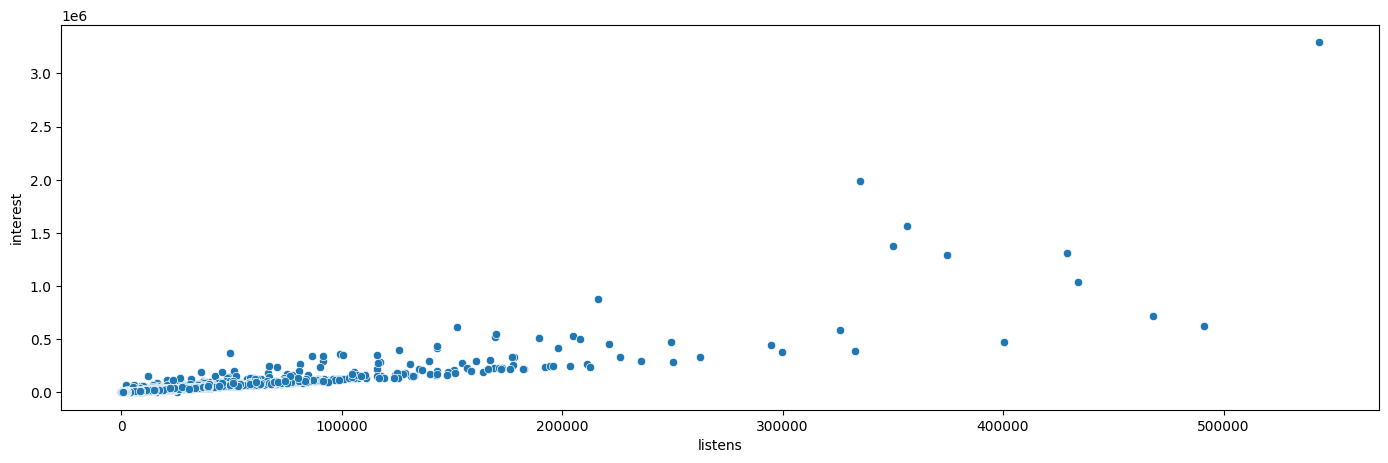

In [19]:
sns.scatterplot(x=tracks.track.listens, y=tracks.track.interest)

    - tracks.track.listens vs tracks.track.interest
        - direction: positive
        - form: linear
        - strength: moderate
        - outliers: yes

<AxesSubplot: xlabel='listens', ylabel='favorites'>

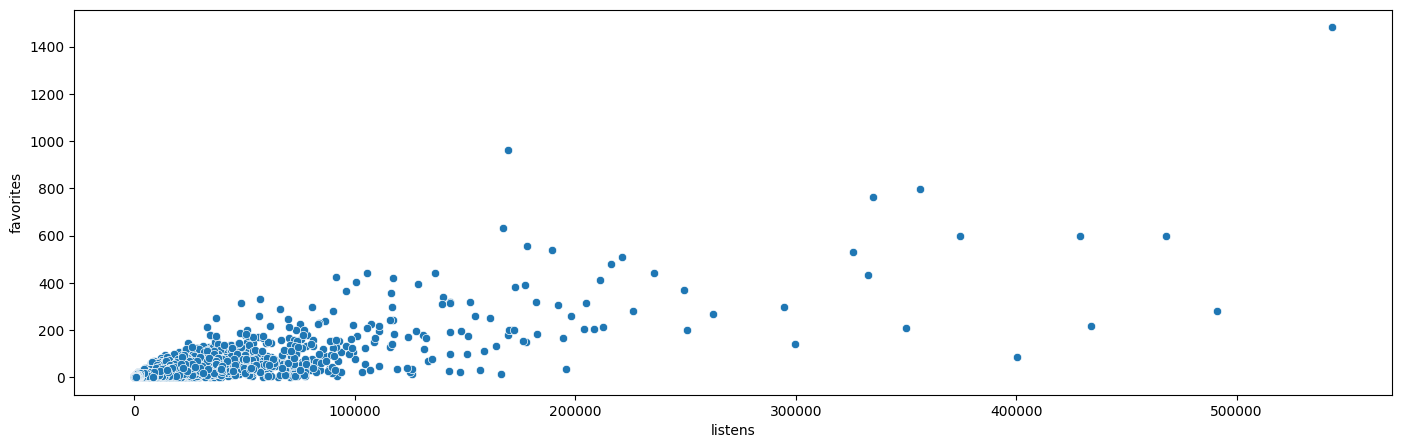

In [20]:
sns.scatterplot(x=tracks.track.listens, y=tracks.track.favorites)

    - tracks.track.listens vs tracks.track.favorites
        - direction: positive
        - form: linear
        - strength: moderate
        - outliers: yes

<AxesSubplot: xlabel='favorites', ylabel='comments'>

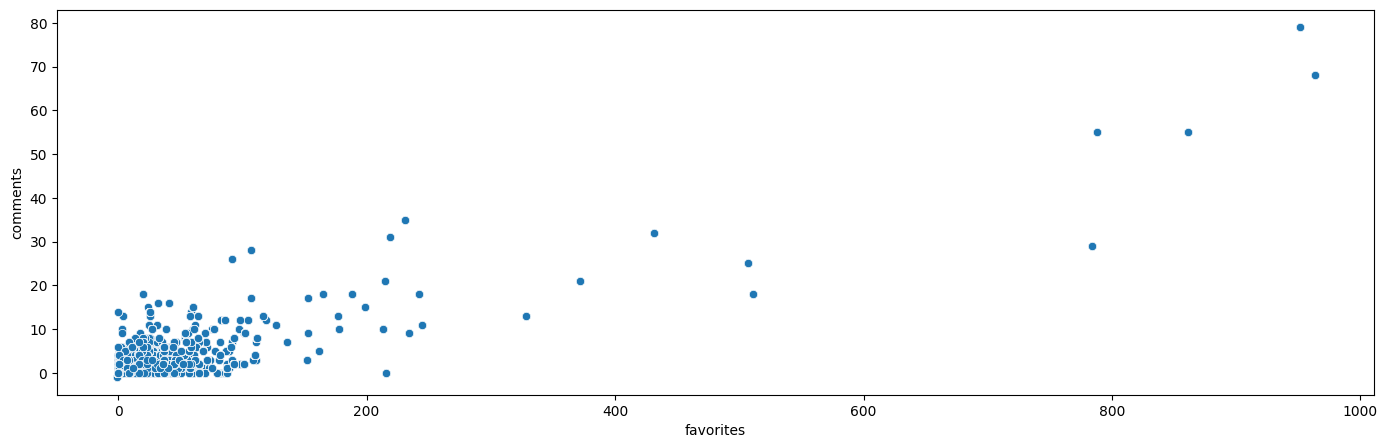

In [21]:
sns.scatterplot(x=tracks.artist.favorites, y=tracks.artist.comments)

    - tracks.artist.favorites vs tracks.artist.comments
        - direction: positive
        - form: non-linear
        - strength: moderate
        - outliers: yes

((2000, 2), (2000,))

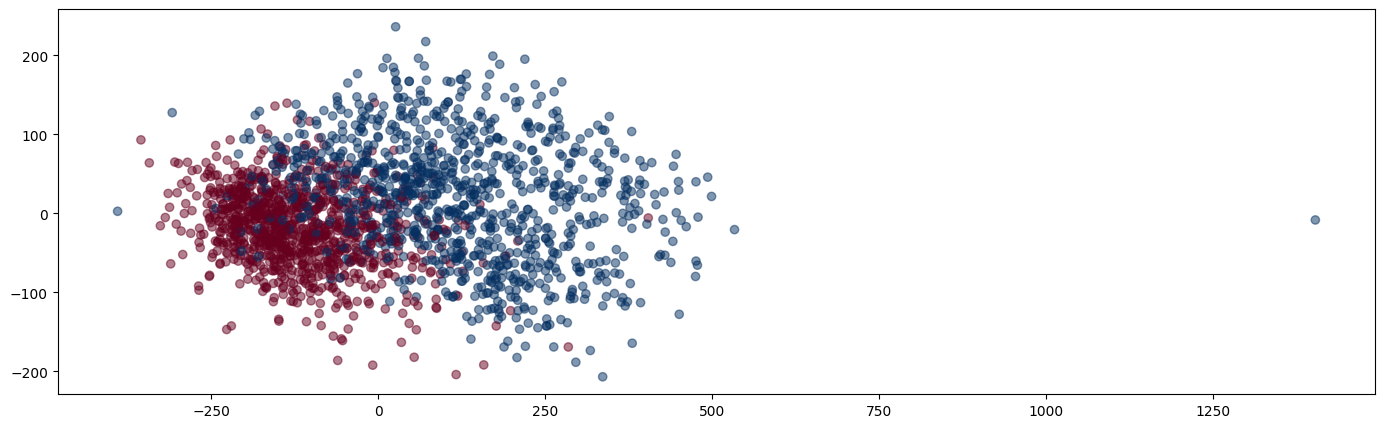

In [22]:
small = tracks['set', 'subset'] <= 'small'
instrumental = tracks['track', 'genre_top'] == 'Instrumental'
hiphop = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (instrumental | hiphop), 'mfcc']
X = PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (instrumental | hiphop), ('track', 'genre_top')]
y = LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

    2. Genres

In [23]:
genres.head()

#tracks  parent          title  top_level
genre_id                                           
1            8693      38    Avant-Garde         38
2            5271       0  International          2
3            1752       0          Blues          3
4            4126       0           Jazz          4
5            4106       0      Classical          5

In [24]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 1 to 1235
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   #tracks    163 non-null    int64 
 1   parent     163 non-null    int64 
 2   title      163 non-null    object
 3   top_level  163 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [25]:
genres.describe()

#tracks       parent    top_level
count    163.000000   163.000000   163.000000
mean    2142.085890    60.447853    51.374233
std     5199.542574   185.396011   211.470836
min        0.000000     0.000000     2.000000
25%      125.000000     5.000000     5.000000
50%      563.000000    15.000000    12.000000
75%     1846.500000    38.000000    20.000000
max    38154.000000  1235.000000  1235.000000

In [26]:
genres.columns

Index(['#tracks', 'parent', 'title', 'top_level'], dtype='object')

In [27]:
genres.dtypes

#tracks       int64
parent        int64
title        object
top_level     int64
dtype: object

In [28]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


#tracks  parent                title  top_level
genre_id                                                 
38          38154       0         Experimental         38
15          34413       0           Electronic         15
12          32923       0                 Rock         12
1235        14938       0         Instrumental       1235
10          13845       0                  Pop         10
17          12706       0                 Folk         17
21           8389       0              Hip-Hop         21
2            5271       0        International          2
4            4126       0                 Jazz          4
5            4106       0            Classical          5
9            1987       0              Country          9
20           1876       0               Spoken         20
3            1752       0                Blues          3
14           1499       0             Soul-RnB         14
8             868       0  Old-Time / Historic          8
13            730       0       Easy Listening         13

In [29]:
genres.sort_values('#tracks').head(10)

#tracks  parent                     title  top_level
genre_id                                                      
175             0      86                 Bollywood          2
178             0       4                    Be-Bop          4
377             1      19                 Deep Funk         14
173             4      86     N. Indian Traditional          2
493             4     651             Western Swing          9
374             9      20                    Banter         20
808            12      46                     Salsa          2
174            17      86  South Indian Traditional          2
465            18      20           Musical Theater         20
176            23       2                   Pacific          2

<AxesSubplot: >

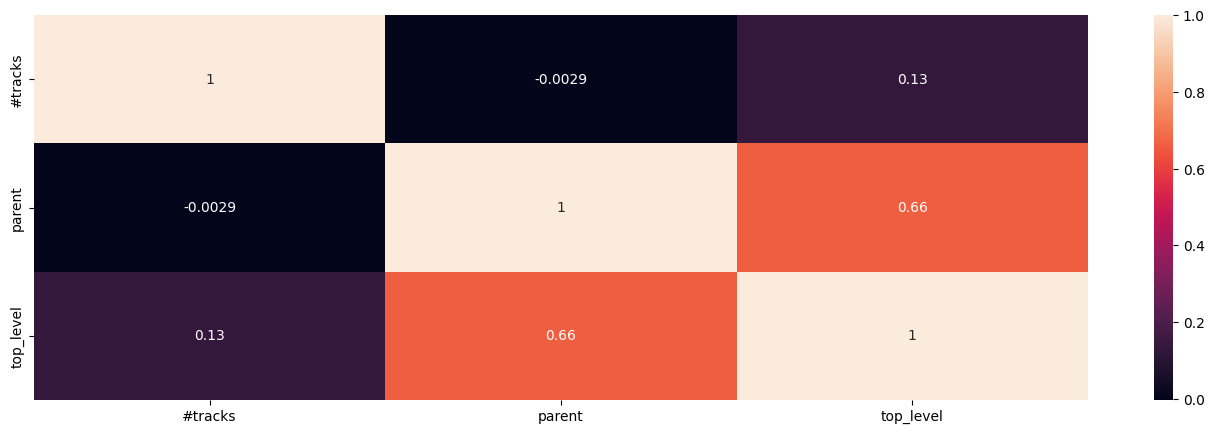

In [30]:
sns.heatmap(genres.corr(numeric_only=True), annot=True)

    3. Features

In [31]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [32]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Columns: 518 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'std', '01')
dtypes: float64(518)
memory usage: 422.0 MB


In [33]:
features.describe()

feature       chroma_cens                                               \
statistics       kurtosis                                                
number                 01             02             03             04   
count       106574.000000  106574.000000  106574.000000  106574.000000   
mean             0.439999       0.199756       0.334683       0.270263   
std             32.285524      11.120903       9.980692      19.074557   
min             -1.955806      -1.936607      -1.967450      -3.000000   
25%             -0.636597      -0.665684      -0.629114      -0.644747   
50%             -0.176557      -0.221131      -0.152708      -0.191032   
75%              0.485000       0.410097       0.529836       0.446800   
max           8843.367188    2864.075195    1777.615967    4257.045898   

feature                                                                 \
statistics                                                               
number                 05             06             07             08   
count       106574.000000  106574.000000  106574.000000  106574.000000   
mean             0.294806       0.315635       0.273511       0.334927   
std             15.025603      12.176182      16.975991      15.486402   
min             -1.921206      -1.923740      -1.935382      -3.000000   
25%             -0.656779      -0.622579      -0.646798      -0.635741   
50%             -0.198025      -0.152089      -0.187959      -0.161478   
75%              0.452680       0.513112       0.472161       0.525814   
max           3188.034424    2809.779297    4281.090820    3869.482178   

feature                                   ...        tonnetz                 \
statistics                                ...            std                  
number                 09             10  ...             04             05   
count       106574.000000  106574.000000  ...  106574.000000  106574.000000   
mean             0.201939       0.285631  ...       0.098667       0.021569   
std              7.364308       8.175257  ...       0.037101       0.006076   
min             -3.000000      -3.000000  ...       0.005681       0.000087   
25%             -0.667799      -0.660292  ...       0.071240       0.017226   
50%             -0.214547      -0.181836  ...       0.093500       0.020636   
75%              0.432480       0.495568  ...       0.121007       0.024990   
max           1217.209473    1772.918213  ...       0.332470       0.092869   

feature                              zcr                                \
statistics                      kurtosis            max           mean   
number                 06             01             01             01   
count       106574.000000  106574.000000  106574.000000  106574.000000   
mean             0.021880      29.464638       0.381368       0.052755   
std              0.006125      88.975395       0.183414       0.032634   
min              0.000368      -1.967539       0.010254       0.000055   
25%              0.017542       3.316640       0.246582       0.032913   
50%              0.020964       9.714652       0.357910       0.047077   
75%              0.025252      26.981386       0.471680       0.064616   
max              0.116128    8438.014648       0.999512       0.878024   

feature                                                                 
statistics         median            min           skew            std  
number                 01             01             01             01  
count       106574.000000  106574.000000  106574.000000  106574.000000  
mean             0.043576       0.002342       3.214247       0.040303  
std              0.031703       0.005152       3.045345       0.027259  
min              0.000000       0.000000     -15.727972       0.000436  
25%              0.024902       0.000000       1.400700       0.022054  
50%              0.037598       0.000000       2.404834       0.033566  
75%              0.054199   

In [34]:
features.columns

MultiIndex([('chroma_cens', 'kurtosis', '01'),
            ('chroma_cens', 'kurtosis', '02'),
            ('chroma_cens', 'kurtosis', '03'),
            ('chroma_cens', 'kurtosis', '04'),
            ('chroma_cens', 'kurtosis', '05'),
            ('chroma_cens', 'kurtosis', '06'),
            ('chroma_cens', 'kurtosis', '07'),
            ('chroma_cens', 'kurtosis', '08'),
            ('chroma_cens', 'kurtosis', '09'),
            ('chroma_cens', 'kurtosis', '10'),
            ...
            (    'tonnetz',      'std', '04'),
            (    'tonnetz',      'std', '05'),
            (    'tonnetz',      'std', '06'),
            (        'zcr', 'kurtosis', '01'),
            (        'zcr',      'max', '01'),
            (        'zcr',     'mean', '01'),
            (        'zcr',   'median', '01'),
            (        'zcr',      'min', '01'),
            (        'zcr',     'skew', '01'),
            (        'zcr',      'std', '01')],
           names=['feature', 'statistics', 

In [35]:
features.dtypes

feature      statistics  number
chroma_cens  kurtosis    01        float64
                         02        float64
                         03        float64
                         04        float64
                         05        float64
                                    ...   
zcr          mean        01        float64
             median      01        float64
             min         01        float64
             skew        01        float64
             std         01        float64
Length: 518, dtype: object

In [36]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast',
           ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'], ['rmse', 'zcr']]
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


    4. Echonest (Spotify)

In [37]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

In [38]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 2 to 124911
Columns: 249 entries, ('echonest', 'audio_features', 'acousticness') to ('echonest', 'temporal_features', '223')
dtypes: float64(244), object(5)
memory usage: 25.0+ MB


In [39]:
echonest.describe()

echonest                                               \
      audio_features                                                
        acousticness  danceability        energy instrumentalness   
count   1.312900e+04  13129.000000  13129.000000     13129.000000   
mean    5.246876e-01      0.487290      0.537516         0.640536   
std     3.837186e-01      0.190148      0.278049         0.361430   
min     9.035000e-07      0.051307      0.000020         0.000000   
25%     1.037726e-01      0.344759      0.321300         0.323466   
50%     5.739848e-01      0.485635      0.549113         0.838134   
75%     9.207270e-01      0.629094      0.776254         0.918244   
max     9.957965e-01      0.968645      0.999964         0.998016   

                                                                               \
                                                                     metadata   
           liveness   speechiness         tempo       valence artist_latitude   
count  13129.000000  13129.000000  13129.000000  13129.000000     9770.000000   
mean       0.187804      0.099174    123.080061      0.439761       39.961892   
std        0.158051      0.137381     35.015137      0.276028       15.554275   
min        0.025297      0.022324     12.753000      0.000010      -45.867100   
25%        0.101406      0.036932     95.967000      0.197321       37.784827   
50%        0.119002      0.049019    120.057000      0.417743       40.781400   
75%        0.211041      0.085452    145.318000      0.665575       47.254575   
max        0.980330      0.966177    251.072000      0.999990       68.927500   

                        ...                                                \
                        ... temporal_features                               
      artist_longitude  ...               214           215           216   
count      9770.000000  ...      13129.000000  13129.000000  13129.000000   
mean        -49.984040  ...         -1.966002     10.745951      0.308984   
std          59.377974  ...          1.708499     20.053146      0.140164   
min        -155.434000  ...        -17.966162     -1.867880      0.129023   
25%         -87.632400  ...         -2.587326      1.229409      0.242371   
50%         -74.007100  ...         -1.565120      4.355214      0.286014   
75%          -0.127140  ...         -0.875471     11.407599      0.339086   
max         174.770000  ...          1.663782    423.621094      5.211423   

                                                                             \
                                                                              
                217           218           219           220           221   
count  13129.000000  13129.000000  13129.000000  13129.000000  13129.000000   
mean       0.255381      0.163876      0.068526      4.183428      4.114902   
std        0.083731      3.484144      0.010930      4.967481      4.967004   
min        0.098280      0.000518      0.060000      0.322180      0.224580   
25%        0.208750      0.021321      0.063080      1.817050      1.749660   
50%        0.242745      0.042146      0.064490      3.094060      3.026260   
75%        0.285305      0.087516      0.070070      5.147530      5.079770   
max        1.680570    375.744781      0.342000    226.326767    226.244080   

                                   
                                   
                222           223  
count  13129.000000  13129.000000  
mean       7.605432    138.932366  
std        6.444884    225.584951  
min       -3.566834     -1.687834  
25%        2.866906     15.565598  
50%        5.502340     55.874954  
75%       10.597994    175.938553  
max       67.041878   4790.696777  

[8 rows x 244 columns]

In [40]:
echonest.columns

MultiIndex([('echonest',    'audio_features',     'acousticness'),
            ('echonest',    'audio_features',     'danceability'),
            ('echonest',    'audio_features',           'energy'),
            ('echonest',    'audio_features', 'instrumentalness'),
            ('echonest',    'audio_features',         'liveness'),
            ('echonest',    'audio_features',      'speechiness'),
            ('echonest',    'audio_features',            'tempo'),
            ('echonest',    'audio_features',          'valence'),
            ('echonest',          'metadata',       'album_date'),
            ('echonest',          'metadata',       'album_name'),
            ...
            ('echonest', 'temporal_features',              '214'),
            ('echonest', 'temporal_features',              '215'),
            ('echonest', 'temporal_features',              '216'),
            ('echonest', 'temporal_features',              '217'),
            ('echonest', 'temporal_features', 

In [41]:
echonest.dtypes

echonest  audio_features     acousticness        float64
                             danceability        float64
                             energy              float64
                             instrumentalness    float64
                             liveness            float64
                                                  ...   
          temporal_features  219                 float64
                             220                 float64
                             221                 float64
                             222                 float64
                             223                 float64
Length: 249, dtype: object

In [42]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


album_date         album_name  artist_latitude  \
track_id                                                   
2                NaN                NaN          32.6783   
3                NaN                NaN          32.6783   
5                NaN                NaN          32.6783   
10        2008-03-11  Constant Hitmaker          39.9523   
134              NaN                NaN          32.6783   

               artist_location  artist_longitude artist_name  \
track_id                                                       
2                  Georgia, US          -83.2230        AWOL   
3                  Georgia, US          -83.2230        AWOL   
5                  Georgia, US          -83.2230        AWOL   
10        Philadelphia, PA, US          -75.1624   Kurt Vile   
134                Georgia, US          -83.2230        AWOL   

                       release  
track_id                        
2         AWOL - A Way Of Life  
3         AWOL - A Way Of Life  
5         AWOL - A Way Of Life  
10           Constant Hitmaker  
134       AWOL - A Way Of Life

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.416675      0.675894  0.634476          0.010628  0.177647   
3             0.374408      0.528643  0.817461          0.001851  0.105880   
5             0.043567      0.745566  0.701470          0.000697  0.373143   
10            0.951670      0.658179  0.924525          0.965427  0.115474   
134           0.452217      0.513238  0.560410          0.019443  0.096567   

          speechiness    tempo   valence  
track_id                                  
2            0.159310  165.922  0.576661  
3            0.461818  126.957  0.269240  
5            0.124595  100.260  0.621661  
10           0.032985  111.562  0.963590  
134          0.525519  114.290  0.894072

artist_discovery  artist_familiarity  artist_hotttnesss  \
track_id                                                            
2                 0.388990            0.386740           0.406370   
3                 0.388990            0.386740           0.406370   
5                 0.388990            0.386740           0.406370   
10                0.557339            0.614272           0.798387   
134               0.388990            0.386740           0.406370   

          song_currency  song_hotttnesss  
track_id                                  
2              0.000000         0.000000  
3              0.000000         0.000000  
5              0.000000         0.000000  
10             0.005158         0.354516  
134            0.000000         0.000000

artist_discovery_rank  artist_familiarity_rank  \
track_id                                                   
2                           NaN                      NaN   
3                           NaN                      NaN   
5                           NaN                      NaN   
10                       2635.0                   2544.0   
134                         NaN                      NaN   

          artist_hotttnesss_rank  song_currency_rank  song_hotttnesss_rank  
track_id                                                                    
2                            NaN                 NaN                   NaN  
3                            NaN                 NaN                   NaN  
5                            NaN                 NaN                   NaN  
10                         397.0            115691.0               67609.0  
134                          NaN                 NaN                   NaN

000       001       002       003       004       005  \
track_id                                                               
2         0.877233  0.588911  0.354243  0.295090  0.298413  0.309430   
3         0.534429  0.537414  0.443299  0.390879  0.344573  0.366448   
5         0.548093  0.720192  0.389257  0.344934  0.361300  0.402543   
10        0.311404  0.711402  0.321914  0.500601  0.250963  0.321316   
134       0.610849  0.569169  0.428494  0.345796  0.376920  0.460590   

               006       007       008       009  ...       214        215  \
track_id                                          ...                        
2         0.304496  0.334579  0.249495  0.259656  ... -1.992303   6.805694   
3         0.419455  0.747766  0.460901  0.392379  ... -1.582331   8.889308   
5         0.434044  0.388137  0.512487  0.525755  ... -2.288358  11.527109   
10        0.734250  0.325188  0.373012  0.235840  ... -3.662988  21.508228   
134       0.401371  0.449900  0.428946  0.446736  ... -1.452696   2.356398   

               216       217       218      219       220       221  \
track_id                                                              
2         0.233070  0.192880  0.027455  0.06408   3.67696   3.61288   
3         0.258464  0.220905  0.081368  0.06413   6.08277   6.01864   
5         0.256821  0.237820  0.060122  0.06014   5.92649   5.86635   
10        0.283352  0.267070  0.125704  0.08082   8.41401   8.33319   
134       0.234686  0.199550  0.149332  0.06440  11.26707  11.20267   

                222         223  
track_id                         
2         13.316690  262.929749  
3         16.673548  325.581085  
5         16.013849  356.755737  
10        21.317064  483.403809  
134       26.454180  751.147705  

[5 rows x 224 columns]

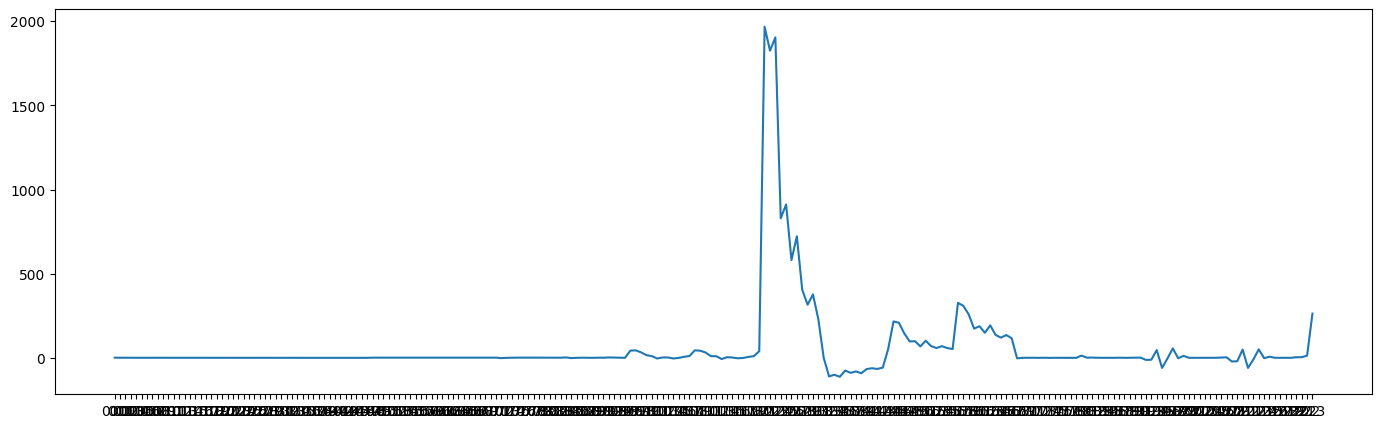

In [43]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### Based on personal observation, this project will dive in building supervised and unsupervised learning models on tracks dataset with a focus on album.comments, album.listens, artist.comments, artist.favorites, track.favorites, track.interest, and track.listens

4. Supervised learning model

    1. [SAMPLE] Perform genre classification analysis with support vector machines

In [44]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [45]:
y_train.head

<bound method NDFrame.head of track_id
2         Hip-Hop
5         Hip-Hop
10            Pop
140          Folk
141          Folk
           ...   
153955        Pop
153956        Pop
154413        Pop
154414        Pop
155066    Hip-Hop
Name: (track, genre_top), Length: 6400, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']>

In [46]:
X_train.head

<bound method NDFrame.head of statistics  kurtosis                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
2           3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
5           2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10          5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
140         0.384906  1.203378  0.429393  0.639471 -0.080144 -0.440946   
141        -0.038922  4.771146 -0.378949 -0.309047 -0.661308 -0.531602   
...              ...       ...       ...       ...       ...       ...   
153955     -0.094801  0.671608  0.272434  0.206937 -0.028461  0.412274   
153956      2.000893  3.728883  1.277116  2.308511  0.184435  0.112066   
154413      1.811922  1.701329  0.074595  1.446981 -0.049799  0.446221   
154414      0.823031  1.711429  0.904345  0.756484 -0.112708  0.160333   
155066  

In [47]:
# shuffle training samples
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# create support vector machines model
clf = SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


    2. [SAMPLE] Multiple classifiers and feature sets

In [48]:
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((25000, 52), (25000, 518))

In [49]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

19922 training examples, 2505 validation examples, 2573 testing examples
Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
All genres (151): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 171, 172, 174, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 651, 659, 695, 741, 763, 808, 810, 811, 906, 1032, 1060, 1193, 1235]


        1. Pre-processing

In [50]:
def pre_process(tracks, features, columns, multi_label=False):
    if not multi_label:
        # assign an integer value to each genre
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
    else:
        # create an indicator matrix
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']


    # split in training, validation and testing sets
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].to_numpy()
    X_val = features.loc[val, columns].to_numpy()
    X_test = features.loc[test, columns].to_numpy()

    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)

    return y_train, y_val, y_test, X_train, X_val, X_test

        2. Building classifiers

            1. Classifiers on single genre

In [51]:
def test_classifiers_features(classifiers, feature_sets, multi_label=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():
            t = time.process_time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t
    return scores, times

def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])

In [52]:
classifiers = {
    # 'LR': LogisticRegression(max_iter=3000),
    'kNN': KNeighborsClassifier(n_neighbors=200),
    # 'SVCrbf': SVC(kernel='rbf'),
    # 'SVCpoly1': SVC(kernel='poly', degree=1),
    # 'linSVC1': SVC(kernel="linear"),
    # 'linSVC2': LinearSVC(max_iter=300000),
    # 'DT': DecisionTreeClassifier(max_depth=5),
    # 'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    # 'AdaBoost': AdaBoostClassifier(n_estimators=10),
    # 'MLP1': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
    # 'MLP2': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
    # 'NB': GaussianNB(),
    # 'QDA': QuadraticDiscriminantAnalysis(),
}

feature_sets = {}
for name in features.columns.levels[0]:
    feature_sets[name] = name
feature_sets.update({
    'mfcc/contrast': ['mfcc', 'spectral_contrast'],
    'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
    'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
    'all_non-echonest': list(features.columns.levels[0])
})

scores, times = test_classifiers_features(classifiers, feature_sets)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))

features:   0%|          | 0/18 [00:00<?, ?it/s]

            2. Classifiers on multiple genres

In [53]:
classifiers = {
    'LR': OneVsRestClassifier(LogisticRegression(max_iter=2000)),
    # 'SVC': OneVsRestClassifier(SVC()),
    # 'MLP': MLPClassifier(max_iter=700),
}

feature_sets = {
    'mfcc': 'mfcc',
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
}

scores, times = test_classifiers_features(classifiers, feature_sets, multi_label=True)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))

features:   0%|          | 0/3 [00:00<?, ?it/s]

    3. LinearRegression + PolynomialFeatures to predict tracks.track.listens

In [54]:
X = new_tracks.loc[:, [('album', 'listens'), ('album', 'comments'), ('artist', 'favorites'), ('artist', 'comments'), ('track', 'interest'), ('track', 'favorites')]]
y = new_tracks.loc[:, [('track', 'listens')]]

In [55]:
X.head()

album             artist             track          
         listens comments favorites comments interest favorites
track_id                                                       
2           6073        0         9        0     4656         2
3           6073        0         9        0     1470         1
5           6073        0         9        0     1933         6
10         47632        0        74        3    54881       178
20          2710        0        10        2      978         0

In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   (album, listens)     106574 non-null  int64
 1   (album, comments)    106574 non-null  int64
 2   (artist, favorites)  106574 non-null  int64
 3   (artist, comments)   106574 non-null  int64
 4   (track, interest)    106574 non-null  int64
 5   (track, favorites)   106574 non-null  int64
dtypes: int64(6)
memory usage: 9.7 MB


In [57]:
y.head()

track
         listens
track_id        
2           1293
3            514
5           1151
10         50135
20           361

In [58]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   (track, listens)  106574 non-null  int64
dtypes: int64(1)
memory usage: 5.7 MB


In [59]:
# normalize
X.loc[:, ('album', 'listens')] = X.loc[:, ('album', 'listens')]/np.max(X.loc[:, ('album', 'listens')])
X.loc[:, ('album', 'comments')] = X.loc[:, ('album', 'comments')]/np.max(X.loc[:, ('album', 'comments')])
X.loc[:, ('artist', 'comments')] = X.loc[:, ('artist', 'comments')]/np.max(X.loc[:, ('artist', 'comments')])
X.loc[:, ('artist', 'favorites')] = X.loc[:, ('artist', 'favorites')]/np.max(X.loc[:, ('artist', 'favorites')])
X.loc[:, ('track', 'favorites')] = X.loc[:, ('track', 'favorites')]/np.max(X.loc[:, ('track', 'favorites')])
X.loc[:, ('track', 'interest')] = X.loc[:, ('track', 'interest')]/np.max(X.loc[:, ('track', 'interest')])
y.loc[:, ('track', 'listens')] = y.loc[:, ('track', 'listens')]/np.max(y.loc[:, ('track', 'listens')])

In [60]:
X.head()

album             artist               track          
           listens comments favorites  comments  interest favorites
track_id                                                           
2         0.001704      0.0  0.009346  0.000000  0.001414  0.001350
3         0.001704      0.0  0.009346  0.000000  0.000446  0.000675
5         0.001704      0.0  0.009346  0.000000  0.000587  0.004049
10        0.013364      0.0  0.076843  0.037975  0.016663  0.120108
20        0.000760      0.0  0.010384  0.025316  0.000297  0.000000

In [61]:
y.head()

track
           listens
track_id          
2         0.002380
3         0.000946
5         0.002119
10        0.092287
20        0.000665

In [62]:
# split the data into training and test dataset (20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(85259, 6) (85259, 1) (21315, 6) (21315, 1)


In [63]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)
print(lm_pred)
lm.score(X_test, y_test)

[[0.00144427]
 [0.00335399]
 [0.00528688]
 ...
 [0.00130121]
 [0.0055217 ]
 [0.00121116]]


0.8031018383933908

In [64]:
pm = make_pipeline(PolynomialFeatures(), LinearRegression())
pm.fit(X_train, y_train)
pm_pred = pm.predict(X_test)
print(pm_pred)
pm.score(X_test, y_test)

[[0.00081741]
 [0.00238804]
 [0.0032592 ]
 ...
 [0.00057575]
 [0.00710199]
 [0.00027623]]


0.8181841738596464

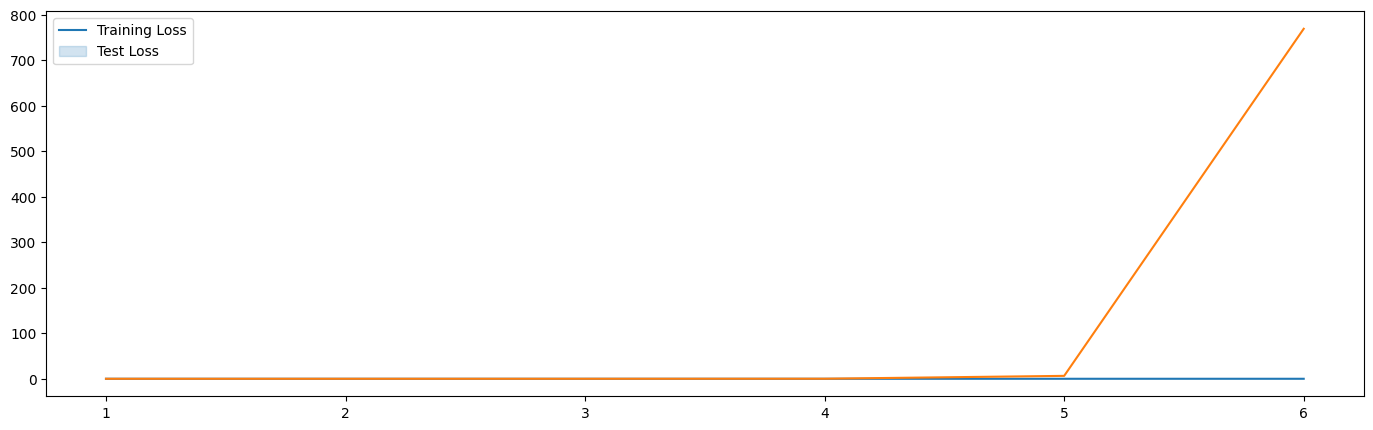

In [65]:
collect_training_loss = []
collect_test_loss = []
collect_m = []
for m in range(1, 7):
    poly_model = make_pipeline(PolynomialFeatures(degree=m),LinearRegression())
    poly_model.fit(X_train, y_train)
    yfit = poly_model.predict(X_test)
    yfit_training = poly_model.predict(X_train)
    collect_test_loss.append(np.sqrt(metrics.mean_squared_error(y_test, yfit)))
    collect_training_loss.append(np.sqrt(metrics.mean_squared_error(y_train, yfit_training)))
    collect_m.append(m)

sns.lineplot(x=collect_m,y=collect_training_loss)
sns.lineplot(x=collect_m,y=collect_test_loss)
plt.legend(labels=['Training Loss', 'Test Loss'])

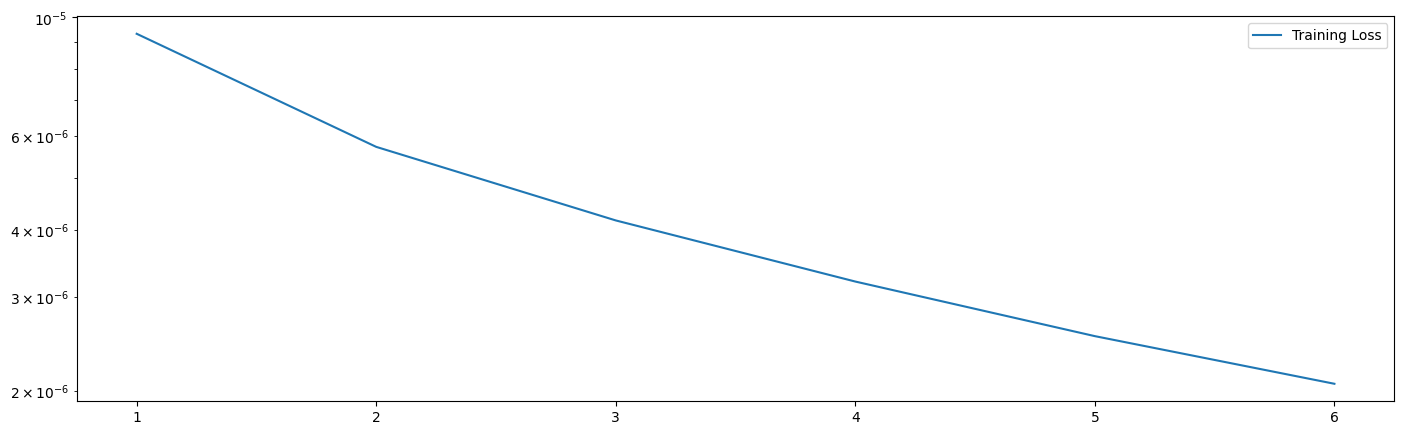

In [66]:
maxi = np.max([np.max(collect_training_loss),np.max(collect_test_loss)])
g_results = sns.lineplot(x=collect_m, y=collect_training_loss/maxi)
g_results.set(yscale='log')
plt.legend(labels=['Training Loss'])

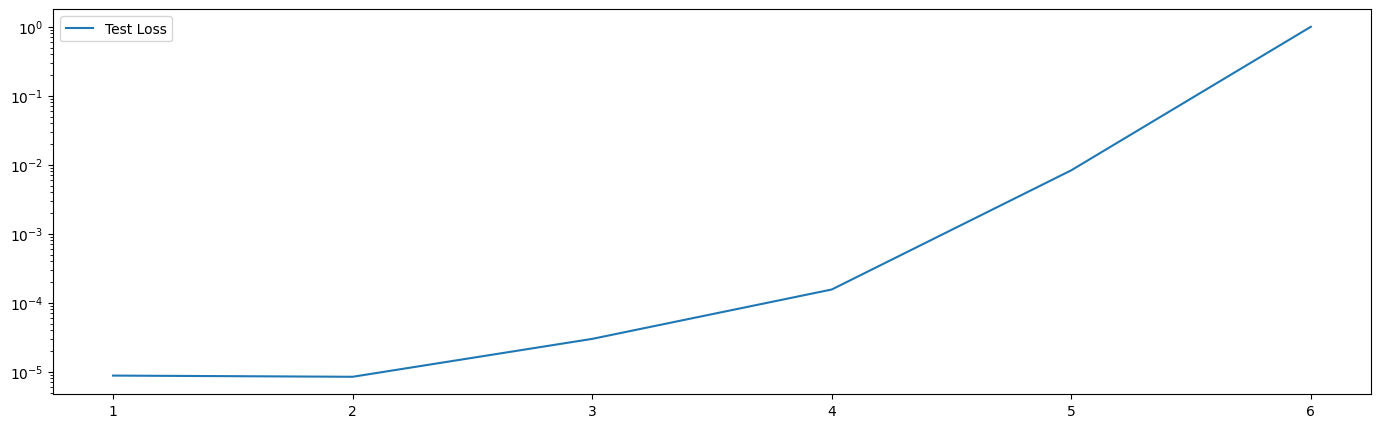

In [67]:
g_results = sns.lineplot(x=collect_m, y=collect_test_loss/maxi)
g_results.set(yscale='log')
plt.legend(labels=['Test Loss'])

The optimal m for PolynomialFeatures is 2 (default)

In [68]:
pm = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
pm.fit(X_train, y_train)
pm_pred = pm.predict(X_test)
print(pm_pred)
pm.score(X_test, y_test)

[[0.00081741]
 [0.00238804]
 [0.0032592 ]
 ...
 [0.00057575]
 [0.00710199]
 [0.00027623]]


0.8181841738596464

In [69]:
print('MAE LM:', metrics.mean_absolute_error(y_test, lm_pred))
print('MSE LM:', metrics.mean_squared_error(y_test, lm_pred))
print('RMSE LM:', np.sqrt(metrics.mean_squared_error(y_test, lm_pred)))
print('MAE PM:', metrics.mean_absolute_error(y_test, pm_pred))
print('MSE PM:', metrics.mean_squared_error(y_test, pm_pred))
print('RMSE PM:', np.sqrt(metrics.mean_squared_error(y_test, pm_pred)))

MAE LM: 0.002042596363675623
MSE LM: 4.591525365424849e-05
RMSE LM: 0.006776079519474996
MAE PM: 0.0011627168470740423
MSE PM: 4.239816008170826e-05
RMSE PM: 0.0065113869553043964


### "The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model." => PolynomialFeatures model predicts better than LinearRegression model in this case. Base on my observation, the models' accuracies can change from time to time. As a result, PolynomialFeatures model predicts better than LinearRegression model sometimes

LinearRegression in Weka

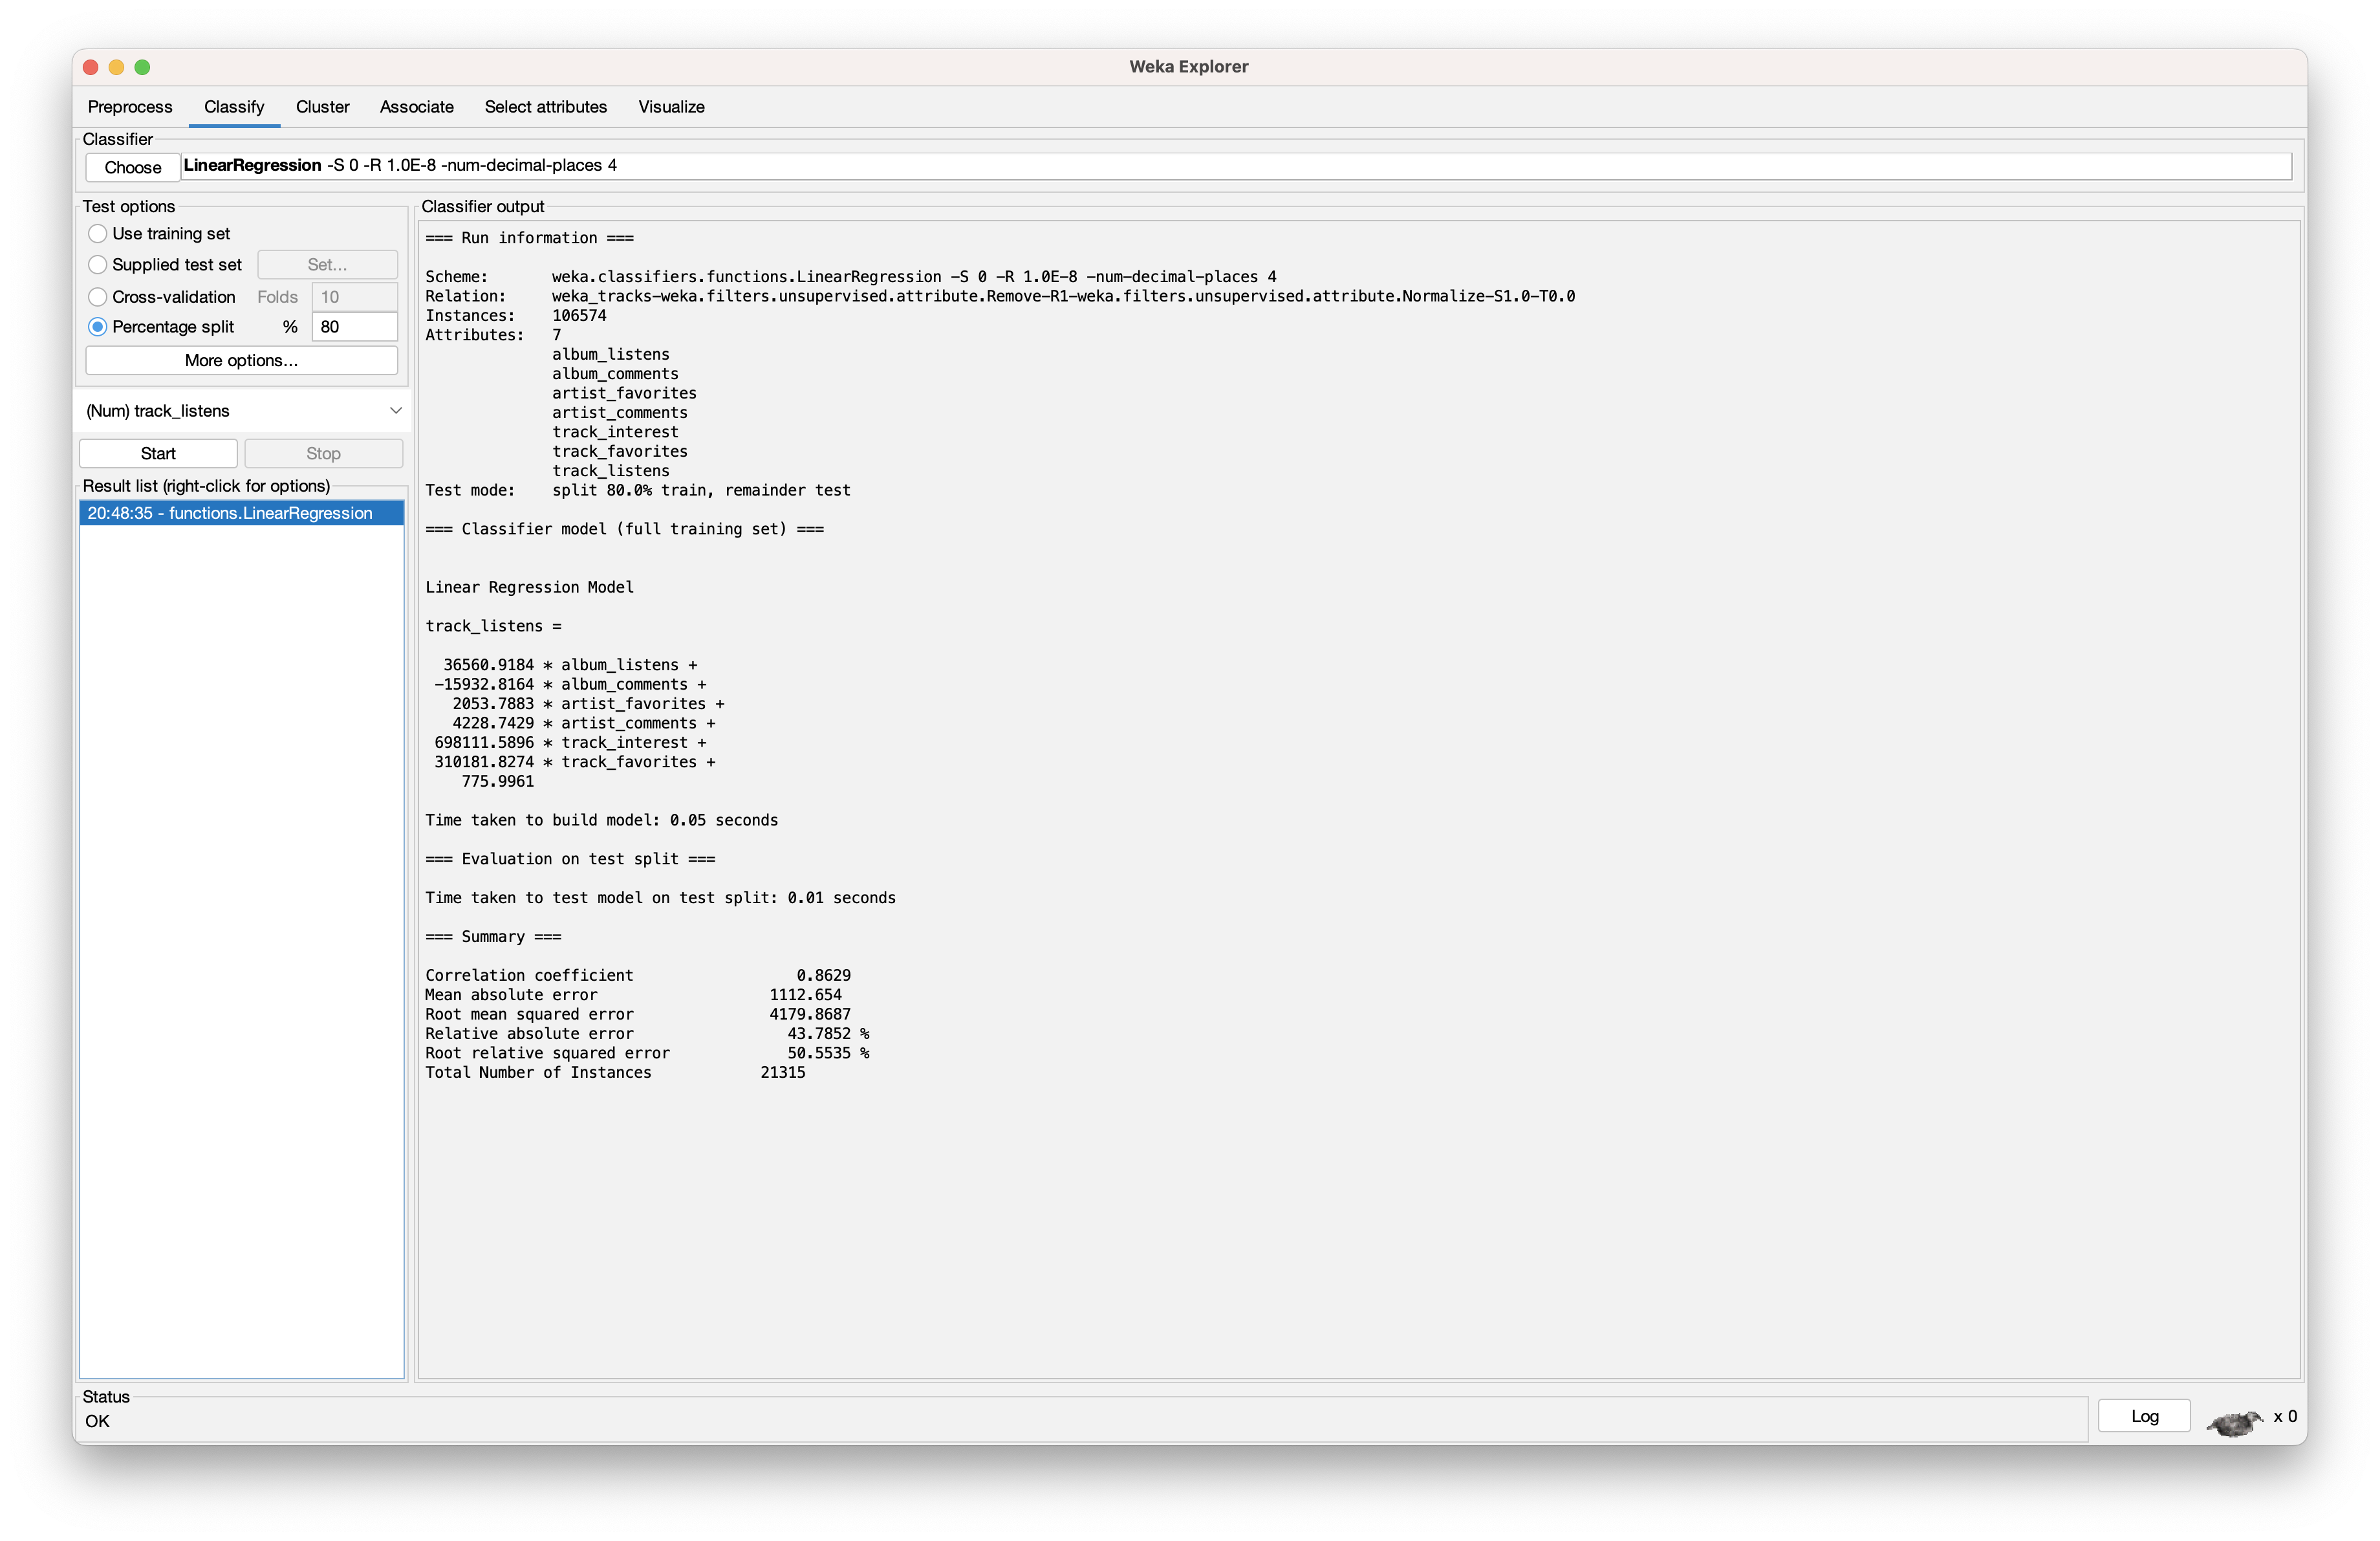

In [70]:
Image(filename='weka_LinearRegression.png')

### The result from Weka looks very close to the one in python

5. Unsupervised learning model

In [71]:
X = new_tracks.loc[:, [('album', 'listens'), ('album', 'comments'), ('artist', 'favorites'), ('artist', 'comments'), ('track', 'interest'), ('track', 'favorites')]]
y_true = new_tracks.loc[:, [('track', 'listens')]]

In [72]:
print(y_true.track.listens.nunique())

12035


In [73]:
# build the k-Means model
n_clusters = y_true.track.listens.nunique()
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
kmeans.fit(X)

# get predictions and center of clusters
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_
print(y_kmeans.shape, centers.shape)

(106574,) (12035, 6)


In [74]:
labels = np.zeros_like(y_kmeans)
for i in range(n_clusters):
    mask = (y_kmeans == i)
    labels[mask] = mode(y_true[mask], keepdims=False)[0]

In [75]:
print('Accuracy score is:',accuracy_score(y_true, labels))

Accuracy score is: 0.12694465817178674


In [76]:
print('The classification report is:\n', classification_report(y_true, labels, zero_division=0))

The classification report is:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        10
           3       0.04      0.06      0.05        16
           4       0.08      0.61      0.13        18
           5       0.04      0.05      0.04        20
           6       0.04      0.11      0.06        19
           7       0.02      0.17      0.04        18
           8       0.07      0.30      0.12        27
           9       0.06      0.23      0.09        26
          10       0.00      0.00      0.00        30
          11       0.00      0.00      0.00        33
          12       0.06      0.29      0.09        38
          13       0.05      0.28      0.08        29
          14       0.03      0.03      0.03        30
          15       0.03      0.17      0.05        29
          16       0.12      0.10      0.11       

KMeans in Weka

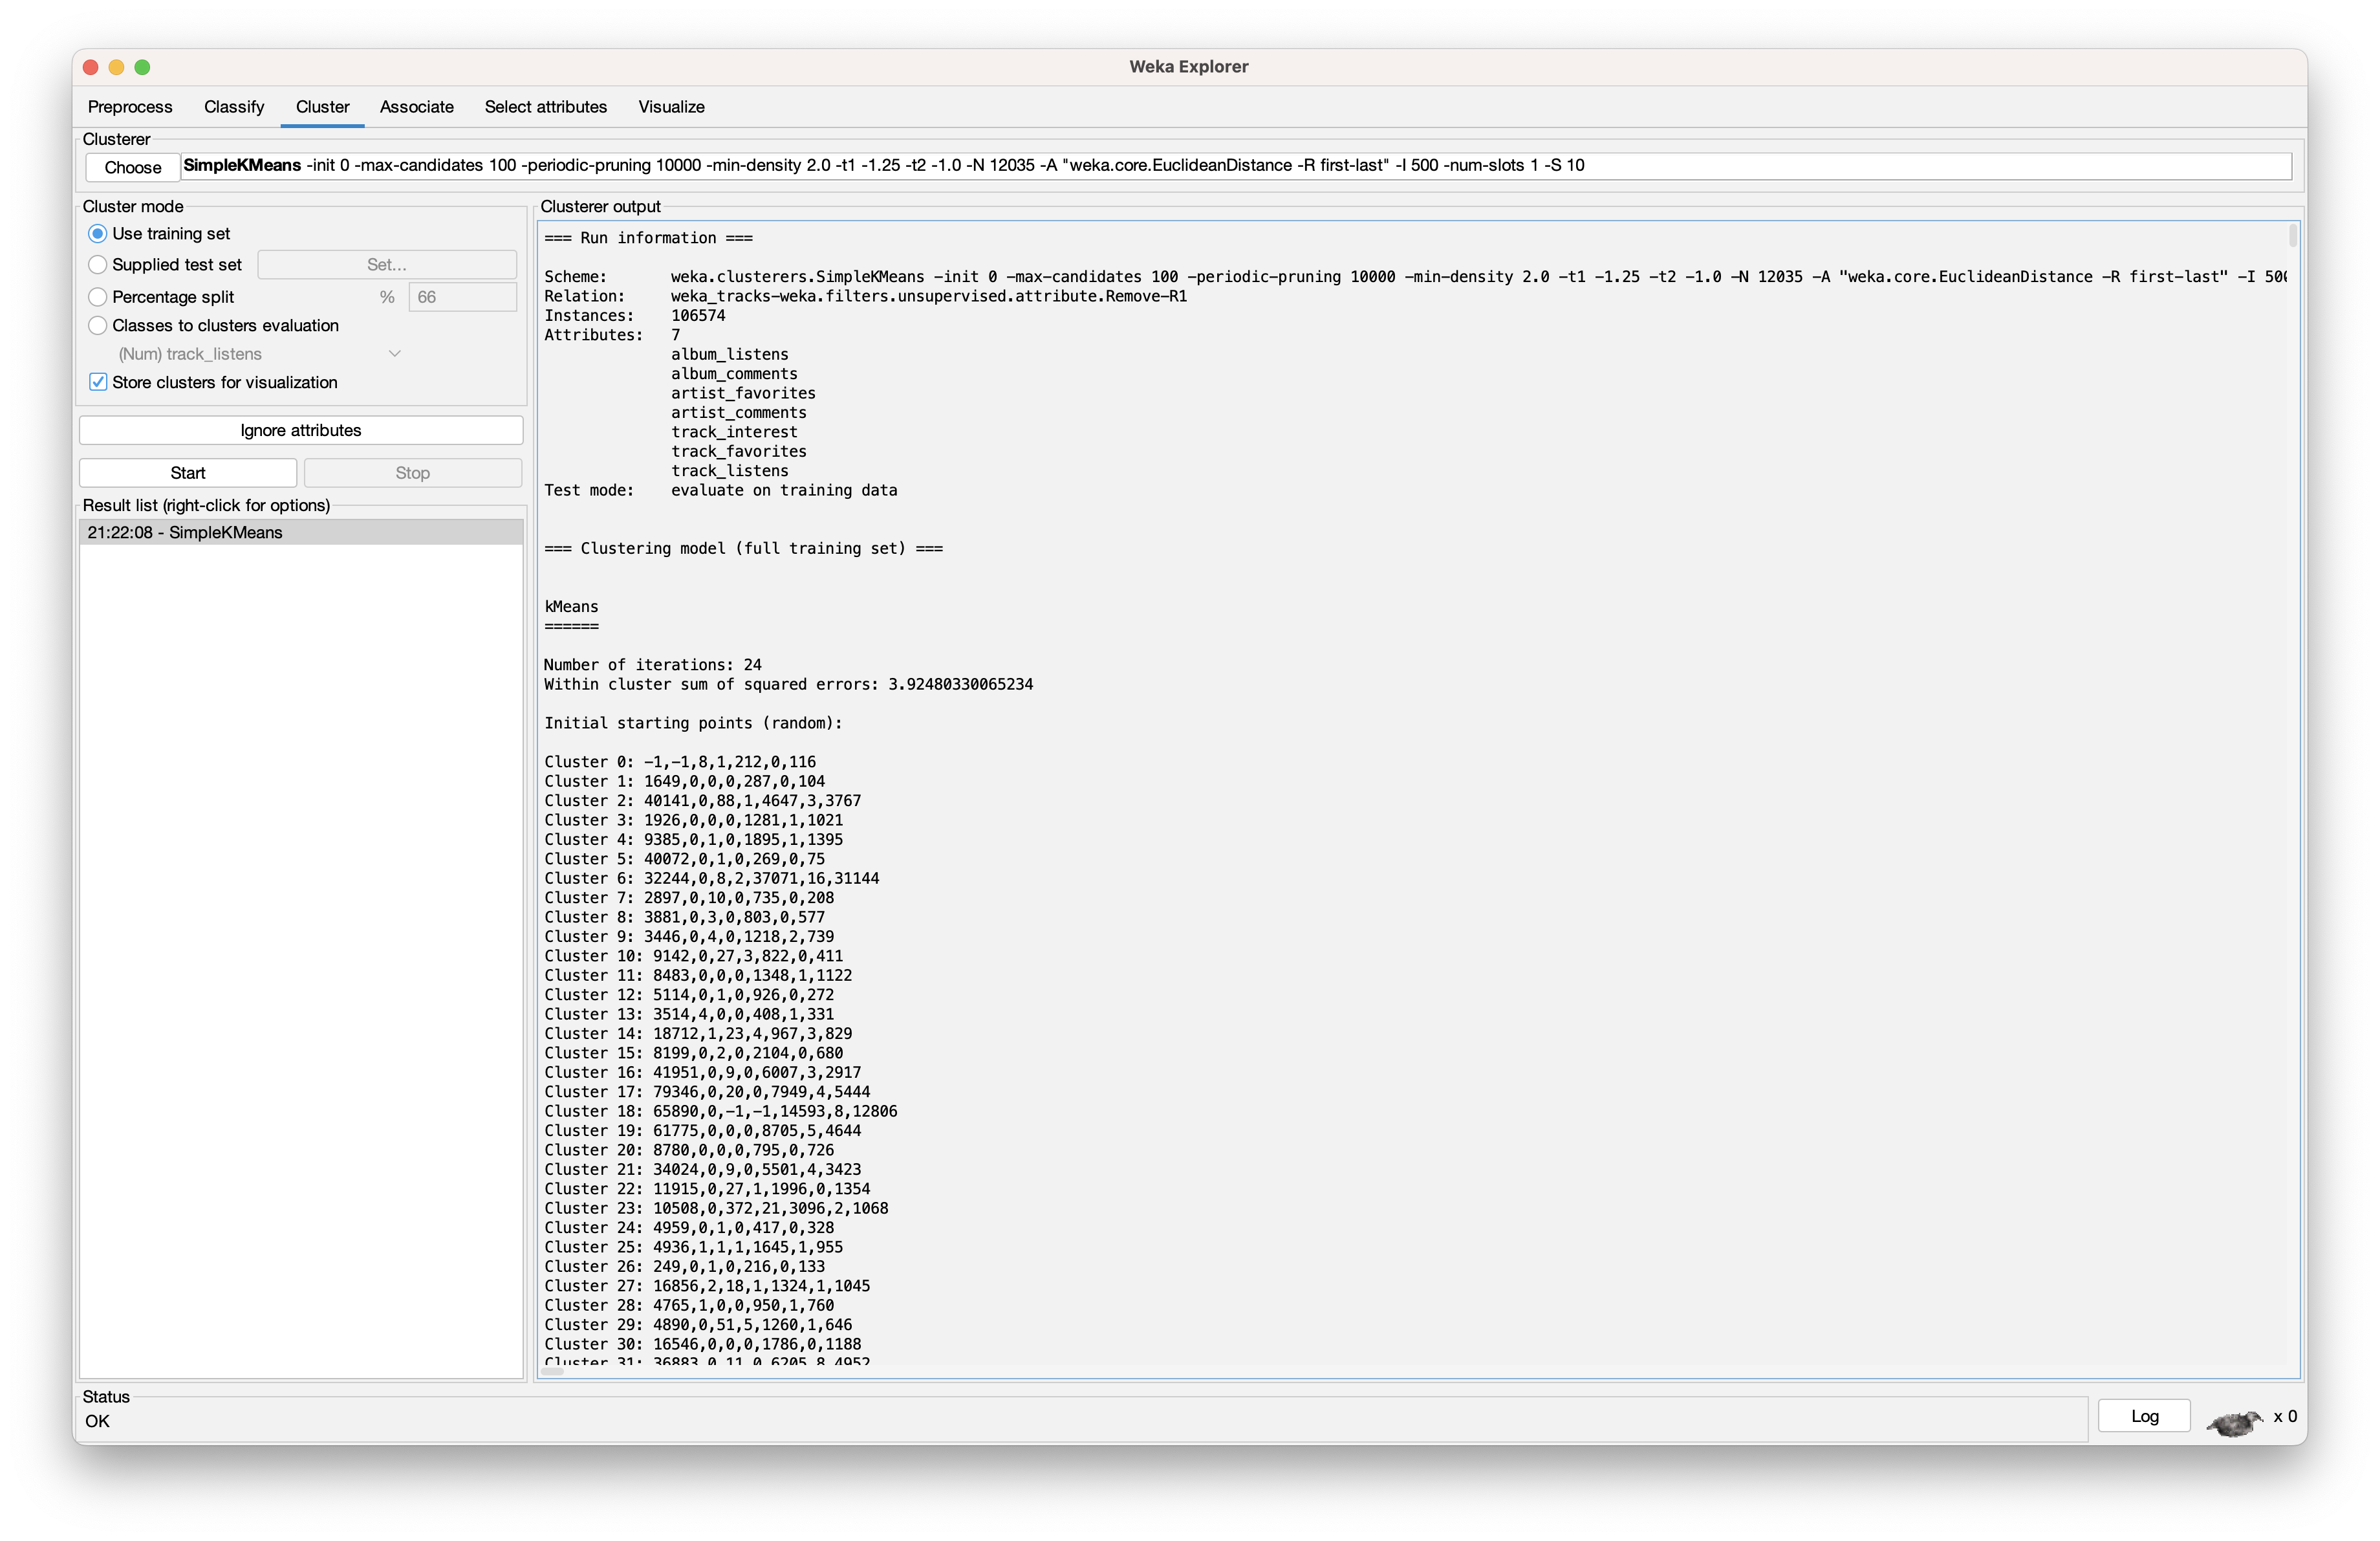

In [77]:
Image(filename='weka_KMeans_1.png')

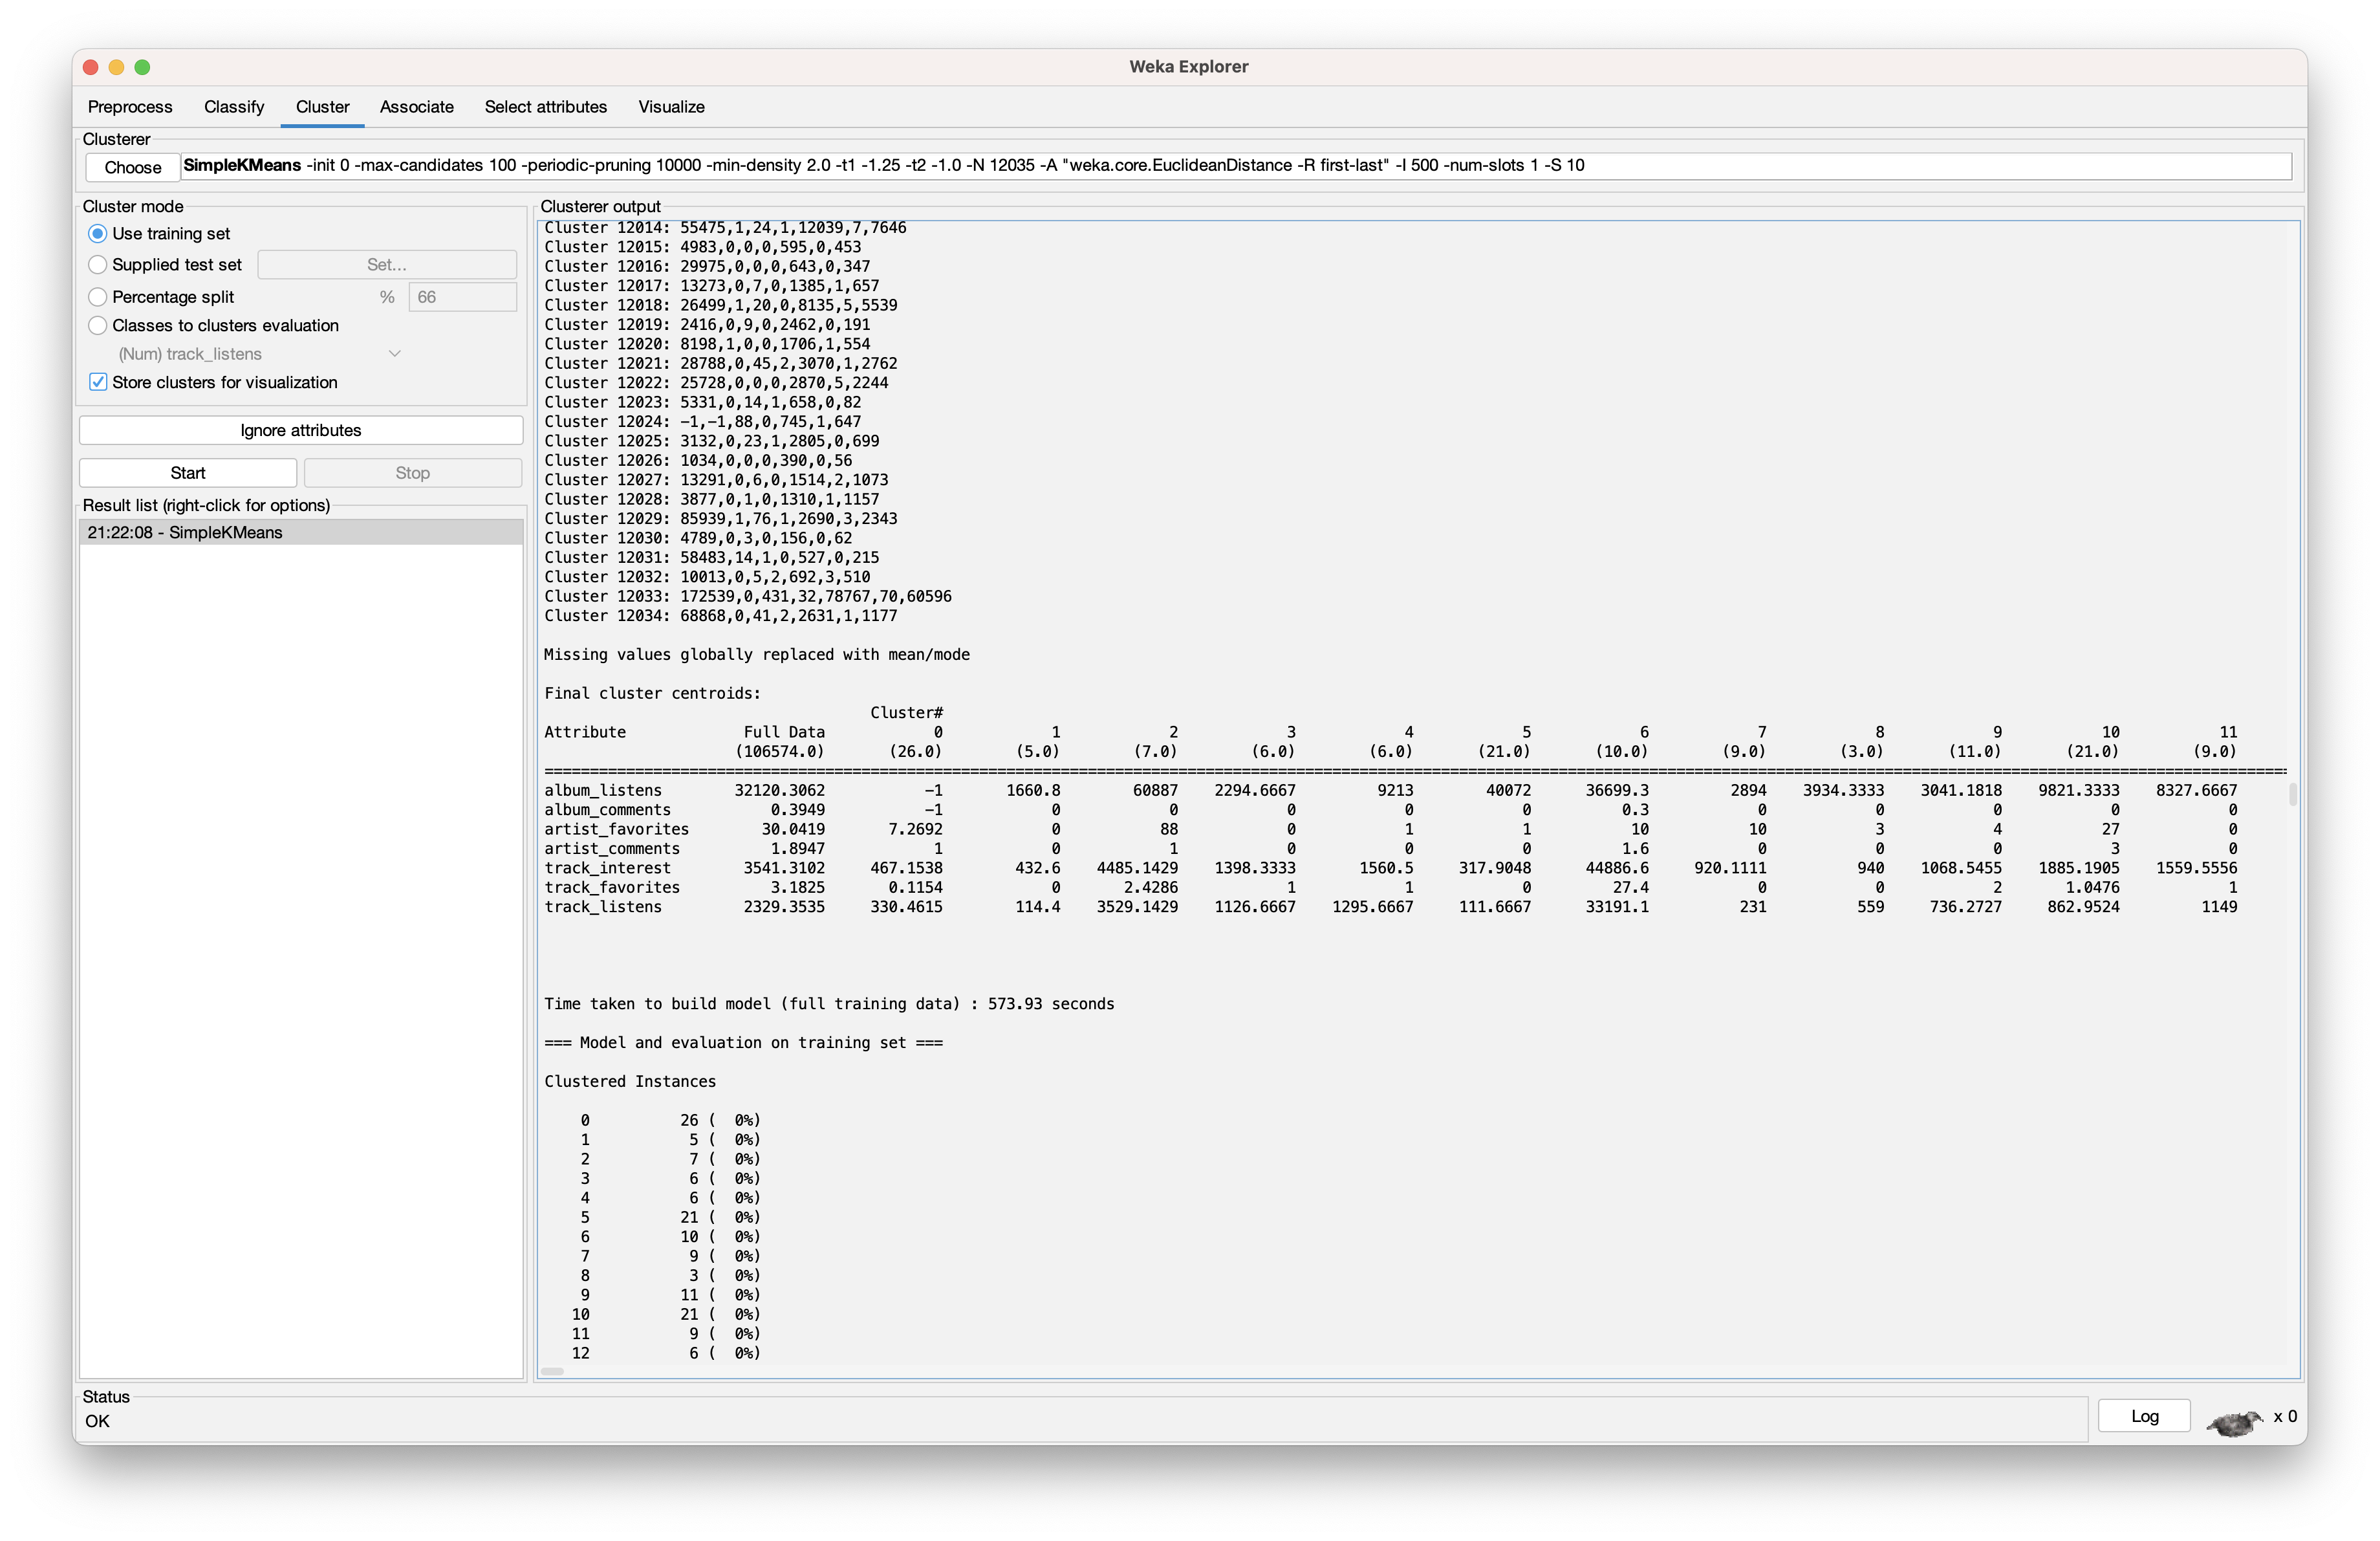

In [78]:
Image(filename='weka_KMeans_2.png')

6. Feature Reduction model

### PCA model to predict tracks.track.listens

In [79]:
X = new_tracks.loc[:, [('album', 'listens'), ('album', 'comments'), ('artist', 'favorites'), ('artist', 'comments'), ('track', 'interest'), ('track', 'favorites')]]
y_true = new_tracks.loc[:, [('track', 'listens')]]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(85259, 6) (85259, 1) (21315, 6) (21315, 1)


In [81]:
scaler = StandardScaler()

# fit on training set only.
scaler.fit(X_train)

# apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
pca = PCA(.95)
pca.fit(X_train)

PCA(n_components=0.95)

In [83]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

7. Prepare data for Weka

In [84]:
new_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   (album, listens)     106574 non-null  int64
 1   (album, comments)    106574 non-null  int64
 2   (artist, favorites)  106574 non-null  int64
 3   (artist, comments)   106574 non-null  int64
 4   (track, interest)    106574 non-null  int64
 5   (track, favorites)   106574 non-null  int64
 6   (track, listens)     106574 non-null  int64
dtypes: int64(7)
memory usage: 10.5 MB


In [85]:
new_tracks.columns = new_tracks.columns.map('_'.join)

In [86]:
new_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   album_listens     106574 non-null  int64
 1   album_comments    106574 non-null  int64
 2   artist_favorites  106574 non-null  int64
 3   artist_comments   106574 non-null  int64
 4   track_interest    106574 non-null  int64
 5   track_favorites   106574 non-null  int64
 6   track_listens     106574 non-null  int64
dtypes: int64(7)
memory usage: 10.5 MB


In [87]:
new_tracks.to_csv('weka_tracks.csv')

8. Conclusion

### This project has given me an opportunity to do an data analysis on a very big and complex dataset, and to build multiple types of models on top of it. Some models took 10-20 minutes to build on a very powerful CPU equiped computer, I tried to play around with TensorFlow to ultize GPU acceleration but it's a very different library compared to the familiar scikit-learn library. At the end, I decided to go with the familiar one due to time constraint. I have tried a number of models and data processing methods, with this dataset and my select features, the built supervised models are performaning way higher than unsupervised one.